## Calcium scoring script
Authors: Niels van der Werf (n.vanderwerf@erasmusmc.nl) / Gijs van Praagh (g.d.van.praagh@umcg.nl)
May 2021 version 1.0

This script will calculate the Agatston, volume, and mass score from a
CT scan of the commercially available QRM phantom with cardiac
calcification insert. Besides that it also calculates some image quality
measurements. 

Please refer to line 2746 and below for the correct input for the script.
For more information about the methods and the validation
of all methods, see https://aapm.onlinelibrary.wiley.com/doi/10.1002/mp.14912

When using this script, please cite our article: van Praagh GD, van der Werf NR, Wang J, van Ommen F, 
Poelhekken K, Slart RH, Fleischmann D,Greuter MJ, Leiner T, Willemink MJ. 
Fully Automated Quantification Method (FQM) of Coronary Calcium in an Anthropomorphic Phantom. 
Med Phys. 2021 May 1. doi: 10.1002/mp.14912. Epub ahead of print. PMID: 33932026.

## Imports

In [53]:
# %pip install -U ipykernel
# %pip install opencv-python
# %pip install matplotlib
# %pip install xlsxwriter
# %pip install tqdm
# %pip install scikit-image

In [54]:
import numpy as np
np.seterr(all='ignore')
import os, os.path
import pydicom
import cv2
import math
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
from scipy.interpolate import RegularGridInterpolator as rgi
import collections
import copy
import xlsxwriter
from datetime import date
from tqdm import tqdm
import statistics
import gc
from skimage.transform import rotate
import scipy.interpolate as inter
from scipy.ndimage.interpolation import shift
from numpy.polynomial import Polynomial as Poly
from operator import itemgetter
from itertools import *
from scipy import optimize

## Function definitions

### General definitions

In [55]:
def dcm_list_builder(path, test_text = ""):
    # function to get list of dcm_files from dcm directory
    dcm_path_list = []
    for (dirpath, dirnames, filenames) in os.walk(path, topdown=True):
        if dirpath not in dcm_path_list:
            for filename in filenames:
                try:
                    tmp_str = str(os.path.join(dirpath, filename))
                    ds = pydicom.read_file(tmp_str, stop_before_pixels = True)
                    if dirpath not in dcm_path_list:
                        dcm_path_list.append(dirpath)
                except:
                    pass
            else:
                pass
    return dcm_path_list

In [56]:
def dcm_reader(dcm_path):
    #read dcm_files from path
    #path certainly contains DCM files, as tested by dcm_list_builder function
    dcm_files = []
    for (dirpath, dirnames, filenames) in os.walk(dcm_path,topdown=False):
        for filename in filenames:
            try:
                if not filename == 'DIRFILE':   
                    dcm_file = str(os.path.join(dirpath, filename))
                    pydicom.read_file(dcm_file, stop_before_pixels = True)
                    dcm_files.append(dcm_file)
            except:
                pass

    read_RefDs = True
    while read_RefDs:
        for index in range(len(dcm_files)):
            try:
                RefDs = pydicom.read_file(dcm_files[index], stop_before_pixels = False)
                read_RefDs = False
                break
            except:
                pass
    
    slice_thick_ori = RefDs.SliceThickness
    
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(dcm_files))
    dcm_array = np.zeros([ConstPixelDims[0],ConstPixelDims[1],len(dcm_files)],\
                          dtype=RefDs.pixel_array.dtype) 

    instances = []    
    for filenameDCM in dcm_files:
        try:
            ds = pydicom.read_file(filenameDCM, stop_before_pixels = True)
            instances.append(int(ds.InstanceNumber))
        except:
            pass
    
    instances.sort()

    index = 0
    for filenameDCM in dcm_files:
        try:
            ds = pydicom.read_file(filenameDCM)
            dcm_array[:,:,instances.index(ds.InstanceNumber)] = ds.pixel_array
            if ds.InstanceNumber in instances[:2]:
                if ds.InstanceNumber == instances[0]:
                    loc_1 = ds.SliceLocation
                else:
                    loc_2 = ds.SliceLocation
            index += 1
        except:
            pass
        
    try:
        RefDs.SliceThickness = abs(loc_1 - loc_2)
    except:
        pass
        
        
    dcm_array = dcm_array * RefDs.RescaleSlope + RefDs.RescaleIntercept
    return RefDs, dcm_array, slice_thick_ori

In [57]:
def threshold_def(calcium_threshold_declaration):
    if calcium_threshold_declaration == 'default':
        if header.KVP == 120:
            return 130
        elif header.KVP == 100:
            return 147
    elif calcium_threshold_declaration == 'monoE':
        if 'ME40KEV' in header.ImageType:
            return 339
        elif 'ME50KEV' in header.ImageType:
            return 229
        elif 'ME60KEV' in header.ImageType:
            return 167
        elif 'ME70KEV' in header.ImageType:
            return 132
        elif 'ME80KEV' in header.ImageType:
            return 110
        elif 'ME90KEV' in header.ImageType:
            return 97
        elif 'ME100KEV' in header.ImageType:
            return 87
        elif 'ME110KEV' in header.ImageType:
            return 81
        elif 'ME120KEV' in header.ImageType:
            return 77
        elif 'ME130KEV' in header.ImageType:
            return 73
        elif 'ME140KEV' in header.ImageType:
            return 71
        elif 'ME150KEV' in header.ImageType:
            return 69
        elif 'ME160KEV' in header.ImageType:
            return 67
        elif 'ME170KEV' in header.ImageType:
            return 66
        elif 'ME180KEV' in header.ImageType:
            return 65
        elif 'ME190KEV' in header.ImageType:
            return 64
        else:
            return 130

    else:
        # if header.ConvolutionKernel == 'Sa36f'\
        #     or header.ConvolutionKernel == 'Qr36f'\
        #     or header.ConvolutionKernel[0] == 'Sa36f':
        #         # kVp - base HU pair values are taken from high-dose scans
        #         kVp_baseHU = {'70':-4, '80':12, '90':22, '100':29, '110':33,\
        #                       '120':35, '130':41, '140':44, '150':46, 'Sn100':48, 'Sn150': 70}
        #         # calculation of treshold based on Siemens white-paper
        #         if 'SN' in header.FilterType:
        #             threshold = 95 + kVp_baseHU['Sn' + str(header.KVP)]
        #         else:
        #             threshold = 95 + kVp_baseHU[str(header.KVP)]
        if header.ConvolutionKernel == 'Sa36f' or header.ConvolutionKernel[0] == 'Sa36f':
            threshold = 130
        elif header.KVP == 100:
            threshold = 147
        else:
            threshold = 130
    return threshold

In [58]:
def scoring_method_selector():
    if scoring_method == 'default':
        if ('TOSHIBA' in header.Manufacturer or 'Toshiba' in header.Manufacturer):
            return 'CANON'
        elif ('CANON' in header.Manufacturer or 'Canon' in header.Manufacturer):
            return 'CANON'
        elif ('SIEMENS' in header.Manufacturer or 'Siemens' in header.Manufacturer):
            return 'SIEMENS'
        elif ('PHILIPS' in header.Manufacturer or 'Philips' in header.Manufacturer):
            return 'Philips'
        elif ('GE' in header.Manufacturer or 'Ge' in header.Manufacturer):
            return 'GE'       
        else:
            print('Manufacturer unknown, consider specifying')
            return header.Manufacturer.upper()
        
    elif (scoring_method == 'Siemens' or scoring_method == 'Siemens'):
        return 'SIEMENS'
    elif (scoring_method == 'Canon' or scoring_method == 'CANON'):
        return 'CANON'
    elif (scoring_method == 'Toshiba' or scoring_method == 'TOSHIBA'):
        return 'CANON'
    elif (scoring_method == 'Philips' or scoring_method == 'PHILIPS'):
        return 'PHILIPS'
    elif (scoring_method == 'Ge' or scoring_method == 'GE'):
        return 'GE'
    elif (scoring_method == 'literature'):
        return 'Literature'
    else:
        print('Error, scoring method unknown, using default')
        return header.Manufacturer.upper()

In [59]:
def findCircle(point_1, point_2, point_3): 
    x1, y1 = point_1
    x2, y2 = point_2
    x3, y3 = point_3
    
    x12 = x1 - x2 
    x13 = x1 - x3  
    y12 = y1 - y2  
    y13 = y1 - y3 
    y31 = y3 - y1  
    y21 = y2 - y1
    x31 = x3 - x1  
    x21 = x2 - x1 
 
    sx13 = x1**2 - x3**2  
    sy13 = y1**2 - y3**2
    sx21 = x2**2 - x1**2  
    sy21 = y2**2 - y1**2  
  
    f = (((sx13) * (x12) + (sy13) * (x12) + (sx21) * (x13) +\
          (sy21) * (x13)) // (2 * ((y31) * (x12) - (y21) * (x13)))) 
              
    g = (((sx13) * (y12) + (sy13) * (y12) + (sx21) * (y13) + (sy21) *\
          (y13)) // (2 * ((x31) * (y12) - (x21) * (y13))))  
  
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0 where centre is (h = -g, k = -f)  
    center_insert = [-g,-f]

    return center_insert

In [60]:
def dcm_masked(array_used = None, radius_val = 95, slice_used_center = None):
    try:
        pixel_size = header.PixelSpacing[0]
    except:
        FOV = header.ReconstructionDiameter
        matrix_size = header.Rows
    
        pixel_size = FOV / matrix_size
    
    radius = (radius_val/2) / pixel_size
    
    central_image = array_used[:,:,slice_used_center].copy()
    
    central_image[central_image > -200] = 0
    central_image[central_image != 0] = 1

    image_kernel = math.ceil(5 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
    central_image = scipy.signal.medfilt2d(central_image, image_kernel)
    
    # plt.imshow(central_image)
    # plt.show()

    center = [int(array_used.shape[0] / 2), int(array_used.shape[1] / 2)]
    
    a = central_image.copy()
    for index in range(int(array_used.shape[1] / 2)):
        if (central_image[center[0] + index, center[1] + index] == 1 and\
            central_image[center[0] + index, center[1] + index + 5] == 1):
            point_1 = [center[0] + index, center[1] + index]
            break
        else:
            a[center[0] + index, center[1] + index] = 2
            pass
    
    for index in range(int(array_used.shape[1] / 2)):
        if (central_image[center[0] + index, center[1] - index] == 1 and\
            central_image[center[0] + index, center[1] - index - 5] == 1):
            point_2 = [center[0] + index, center[1] - index]
            break
        else:
            a[center[0] + index, center[1] - index] = 2
            pass
        
    # x_iter = range(center[0], int(array_used.shape[0]), 1)
    # y_iter = range(center[1], int(array_used.shape[1]), 2)
    # for tmp_x, tmp_y in zip(x_iter, y_iter):
    #     if (central_image[tmp_x, tmp_y] == 1 and central_image[tmp_x + 5, tmp_y + 5] == 1):
    #         point_3 = [tmp_x, tmp_y]
    #         break
    #     else:
    #         a[tmp_x, tmp_y] = 2
    #         pass
        
        
    for index in range(int(array_used.shape[1] / 2)):
        if (central_image[center[0] - index, center[1] - index] == 1 and\
            central_image[center[0] - index, center[1] - index - 5] == 1):
            point_3 = [center[0] - index, center[1] - index]
            break
        else:
            a[center[0] - index, center[1] - index] = 2
            pass
        
    # plt.imshow(a)
    # plt.show()
    
    center_insert = findCircle(point_1, point_2, point_3)

    Y, X = np.ogrid[:header.Rows, :header.Columns]
    dist_from_center = np.sqrt((X - center_insert[1])**2 + (Y-center_insert[0])**2)

    mask = dist_from_center <= radius  
    masked_array = np.zeros_like(array_used)
    for index in range(array_used.shape[2]):
        masked_array[:,:,index] = array_used[:,:,index] * mask

    return masked_array, center_insert, mask

In [61]:
def dcm_masked_QRMAbdomen(radius_val = 95):
 
    try:
        pixel_size = header.PixelSpacing[0]
    except:
        FOV = header.ReconstructionDiameter
        matrix_size = header.Rows
    
        pixel_size = FOV / matrix_size
    
    radius = (radius_val/2) / pixel_size
    
    if phantom == 'CCI':
        if 'QRM-ABDOMEN.XA._.0003' in dcm_name:
            center_insert = [215, 271]
        elif 'QRM-ABDOMEN.XA._.0004' in dcm_name:
            center_insert = [210, 269]
        elif 'QRM-ABDOMEN.XA._.0008' in dcm_name:
            center_insert = [218, 266]
        elif 'QRM-ABDOMEN.XA._.0009' in dcm_name:
            center_insert = [210, 270]
        elif 'QRM-ABDOMEN.XA._.0010' in dcm_name:
            center_insert = [212, 273]
        elif 'QRM-ABDOMEN.XA._.0011' in dcm_name:
            center_insert = [217, 272]
        elif 'QRM-ABDOMEN.XA._.0012' in dcm_name:
            center_insert = [217, 272]
        elif 'QRM-ABDOMEN.XA._.0013' in dcm_name:
            center_insert = [217, 276]
        elif 'QRM-ABDOMEN.XA._.0014' in dcm_name:
            center_insert = [216, 280]
        elif 'QRM-ABDOMEN.XA._.0015' in dcm_name:
            center_insert = [215, 283]
        elif 'QRM-ABDOMEN.XA._.0016' in dcm_name:
            center_insert = [217, 283]
        elif 'QRM-ABDOMEN.XA._.0017' in dcm_name:
            center_insert = [215, 281]
        elif 'QRM-ABDOMEN.XA._.0018' in dcm_name:
            center_insert = [216, 273]
        elif 'QRM-ABDOMEN.XA._.0019' in dcm_name:
            center_insert = [215, 281]
        elif 'QRM-ABDOMEN.XA._.0020' in dcm_name:
            center_insert = [215, 280]
        elif 'QRM-ABDOMEN.XA._.0051' in dcm_name:
            center_insert = [220, 294]
        elif 'QRM-ABDOMEN.XA._.0052' in dcm_name:
            center_insert = [221, 295]
        elif 'QRM-ABDOMEN.XA._.0053' in dcm_name:
            center_insert = [221, 295]
        elif 'QRM-ABDOMEN.XA._.0054' in dcm_name:
            center_insert = [221, 293]
        elif 'QRM-ABDOMEN.XA._.0055' in dcm_name:
            center_insert = [222, 297]
        elif 'QRM-ABDOMEN.XA._.0056' in dcm_name:
            center_insert = [220, 298]
        elif 'QRM-ABDOMEN.XA._.0057' in dcm_name:
            center_insert = [221, 296]
        elif 'QRM-ABDOMEN.XA._.0058' in dcm_name:
            center_insert = [221, 296]
        elif 'QRM-ABDOMEN.XA._.0059' in dcm_name:
            center_insert = [223, 295]
        elif 'QRM-ABDOMEN.XA._.0060' in dcm_name:
            center_insert = [223, 297]
        elif 'QRM-ABDOMEN.XA._.0061' in dcm_name:
            center_insert = [223, 296]
        elif 'QRM-ABDOMEN.XA._.0062' in dcm_name:
            center_insert = [224, 297]
        elif 'QRM-ABDOMEN.XA._.0063' in dcm_name:
            center_insert = [222, 302]
        elif 'QRM-ABDOMEN.XA._.0064' in dcm_name:
            center_insert = [224, 302]
        elif 'QRM-ABDOMEN.XA._.0065' in dcm_name:
            center_insert = [222, 305]
        elif 'Abd_large_rep' in dcm_name:
            center_insert = [224, 254]
        elif 'Abdomen_small' in dcm_name:
            center_insert = [216, 251]

    else:
        if 'Abd_large_rep' in dcm_name:
            center_insert = [219, 256]
        elif 'Abdomen_small' in dcm_name:
            center_insert = [238, 254]
    
    
    Y, X = np.ogrid[:header.Rows, :header.Columns]
    dist_from_center = np.sqrt((X - center_insert[1])**2 + (Y-center_insert[0])**2)

    mask = dist_from_center <= radius  
    masked_array = np.zeros_like(dcm_array)
    for index in range(dcm_array.shape[2]):
        masked_array[:,:,index] = dcm_array[:,:,index] * mask
   
    return masked_array, center_insert, mask

In [62]:
def dcm_interpolation(array):
    # define interpolation method via order:
    array_int = array.copy()
    int_header = copy.deepcopy(header)
    
    int_header.SliceThickness = header.PixelSpacing[0]
    
    # actual interpolation
    steps = [header.Rows + 1, header.Columns + 1, header.SliceThickness]    # original step sizes
    x, y, z = [steps[k] * np.arange(array_int.shape[k]) for k in range(3)]  # original grid
    f = rgi((x, y, z), array_int)    # interpolator
    
    dx, dy, dz = header.Rows, header.Columns,  header.PixelSpacing[0]    # new step sizes
    new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]   # new grid
    new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2))  # reorder axes for evaluation
    new_values = f(new_grid)

    return int_header, new_values

In [63]:
def AS_weight_calc(mask, calcium_image_slice):
    maximum_voxel = (mask * calcium_image_slice).max()
    
    try:
        if calcium_threshold_declaration == 'monoE':
            if 'ME40KEV' in header.ImageType:
                if maximum_voxel >= 1029:
                    AS_weight = 4
                elif maximum_voxel >= 773:
                    AS_weight = 3
                elif maximum_voxel >= 515:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME50KEV' in header.ImageType:
                if maximum_voxel >= 694:
                    AS_weight = 4
                elif maximum_voxel >= 522:
                    AS_weight = 3
                elif maximum_voxel >= 348:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME60KEV' in header.ImageType:
                if maximum_voxel >= 508:
                    AS_weight = 4
                elif maximum_voxel >= 381:
                    AS_weight = 3
                elif maximum_voxel >= 254:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME70KEV' in header.ImageType:
                if maximum_voxel >= 400:
                    AS_weight = 4
                elif maximum_voxel >= 300:
                    AS_weight = 3
                elif maximum_voxel >= 200:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME80KEV' in header.ImageType:
                if maximum_voxel >= 335:
                    AS_weight = 4
                elif maximum_voxel >= 251:
                    AS_weight = 3
                elif maximum_voxel >= 168:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME90KEV' in header.ImageType:
                if maximum_voxel >= 293:
                    AS_weight = 4
                elif maximum_voxel >= 220:
                    AS_weight = 3
                elif maximum_voxel >= 147:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME100KEV' in header.ImageType:
                if maximum_voxel >= 265:
                    AS_weight = 4
                elif maximum_voxel >= 199:
                    AS_weight = 3
                elif maximum_voxel >= 133:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME110KEV' in header.ImageType:
                if maximum_voxel >= 246:
                    AS_weight = 4
                elif maximum_voxel >= 185:
                    AS_weight = 3
                elif maximum_voxel >= 123:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME120KEV' in header.ImageType:
                if maximum_voxel >= 232:
                    AS_weight = 4
                elif maximum_voxel >= 174:
                    AS_weight = 3
                elif maximum_voxel >= 116:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME130KEV' in header.ImageType:
                if maximum_voxel >= 222:
                    AS_weight = 4
                elif maximum_voxel >= 167:
                    AS_weight = 3
                elif maximum_voxel >= 111:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME140KEV' in header.ImageType:
                if maximum_voxel >= 215:
                    AS_weight = 4
                elif maximum_voxel >= 161:
                    AS_weight = 3
                elif maximum_voxel >= 107:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME150KEV' in header.ImageType:
                if maximum_voxel >= 209:
                    AS_weight = 4
                elif maximum_voxel >= 157:
                    AS_weight = 3
                elif maximum_voxel >= 104:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME160KEV' in header.ImageType:
                if maximum_voxel >= 204:
                    AS_weight = 4
                elif maximum_voxel >= 153:
                    AS_weight = 3
                elif maximum_voxel >= 102:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME170KEV' in header.ImageType:
                if maximum_voxel >= 201:
                    AS_weight = 4
                elif maximum_voxel >= 151:
                    AS_weight = 3
                elif maximum_voxel >= 100:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME180KEV' in header.ImageType:
                if maximum_voxel >= 198:
                    AS_weight = 4
                elif maximum_voxel >= 148:
                    AS_weight = 3
                elif maximum_voxel >= 99:
                    AS_weight = 2
                else:
                    AS_weight = 1
            elif 'ME190KEV' in header.ImageType:
                if maximum_voxel >= 195:
                    AS_weight = 4
                elif maximum_voxel >= 147:
                    AS_weight = 3
                elif maximum_voxel >= 98:
                    AS_weight = 2
                else:
                    AS_weight = 1
        else:
            if maximum_voxel >= 400:
                AS_weight = 4
            elif maximum_voxel >= 300:
                AS_weight = 3
            elif maximum_voxel >= 200:
                AS_weight = 2
            else:
                AS_weight = 1
            
    except:
        if maximum_voxel >= 400:
            AS_weight = 4
        elif maximum_voxel >= 300:
            AS_weight = 3
        elif maximum_voxel >= 200:
            AS_weight = 2
        else:
            AS_weight = 1
        
    

    return AS_weight 

In [64]:
def angle_calc(side1, side2):
    #Calculate angle between two sides of rectangular triangle
    if side1 == 0:
        angle = 0
    elif side2 == 0:
        angle = math.pi / 2
    else:
        angle = math.atan(side1 / side2)
    
    return angle

In [65]:
def create_circular_mask(h, w, center_circle, radius_circle):

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center_circle[0])**2 + (Y-center_circle[1])**2)

    mask = dist_from_center <= radius_circle
    
    return mask

In [66]:
def mass_mean_def(array):
    # Calculation of mean value within masked image
    if array.max() == 0:
        mass_mean = 0
    else:
        array[array < calcium_threshold] = 0
        mass_mean = array.sum() / np.count_nonzero(array)

    return mass_mean

### CCI specific definitions

In [67]:
def CCI_calcium_image():
    # threshold array according to calcium_threshold 
    # simultaneously make image binary
    array = dcm_array.copy()
    array[array < 1.1*calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    
    CCI_5mm_num_pixels = int(math.pi * (5/2)**2 / header.PixelSpacing[0]**2)
    cal_rod_num_pixels = int(math.pi * (20/2)**2 / header.PixelSpacing[0]**2)

    image_kernel = math.ceil(5 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
        
    # plt.imshow(array[:,:,20], cmap='bone')
    # plt.xticks(fontsize = 35)
    # plt.yticks(fontsize = 35)
    # plt.show()
    
    slice_dict =  {}
    large_index = []
    cal_rod_dict = {}
    for idx in range(array.shape[2]):
        array_filtered = scipy.signal.medfilt2d(array[:,:,idx], image_kernel)
        output = cv2.connectedComponentsWithStats(array_filtered, comp_connect,cv2.CV_32S)
        count_5mm = 0
        for index in range(1,output[0]):
            if output[2][index][4] in range(int(CCI_5mm_num_pixels * 0.6),\
                     int(CCI_5mm_num_pixels * 1.5)):
                count_5mm += 1
            elif output[2][index][4] in range(int(cal_rod_num_pixels * 0.7),\
                     int(cal_rod_num_pixels * 1.3)):
                cal_rod_dict[index] = [int(output[3][index][1]), int(output[3][index][0])]
        if (count_5mm > 0 and count_5mm < 4):
            slice_dict[idx] = count_5mm
    
        poppable_keys = []
        for key in cal_rod_dict.keys():
            start_coordinate = [cal_rod_dict[key][0], cal_rod_dict[key][1]]
            
            x_right = 0
            while array_filtered[start_coordinate[0], start_coordinate[1] + x_right] == 1:
                x_right += 1
            
            x_left = 0
            while array_filtered[start_coordinate[0], start_coordinate[1] - x_left] == 1:
                x_left += 1
            
            y_top = 0
            while array_filtered[start_coordinate[0] + y_top, start_coordinate[1]] == 1:
                y_top += 1
            
            y_bottom = 0
            while array_filtered[start_coordinate[0] - y_bottom, start_coordinate[1]] == 1:
                y_bottom += 1
                
            x_dist = x_right + x_left
            y_dist = y_top + y_bottom
            
            if x_dist not in range(int(0.7*y_dist), int(1.2*y_dist)):
                poppable_keys.append(key)
            else:
                pass
            
        for key in poppable_keys:
                cal_rod_dict.pop(key)
                
        if len(cal_rod_dict) == 0:
            pass
        else:
            large_index.append(idx)
    # flipped_index = np.where(dcm_array[center[0], center[1], :] == max(dcm_array[center[0], center[1], :]))[0][0]
    flipped_index = int(statistics.median(large_index))

    edge_index = []
    if flipped_index < (dcm_array.shape[2] / 2):
        flipped = -1
        for element in large_index:
            if element > (dcm_array.shape[2] / 2):
                edge_index.append(element)
        if not edge_index:
            pass
        else:
            for index_edge in range(min(edge_index), dcm_array.shape[2]):
                try:
                    del(slice_dict[index_edge])
                except:
                    pass
            for element2 in edge_index:
                large_index.remove(element2)
                
        for element in range(max(large_index)):
            try:
                del(slice_dict[element])
            except:
                pass        
    else:
        flipped = 1
        for element in large_index:
            if element < (dcm_array.shape[2] / 2):
                edge_index.append(element)
        if not edge_index:
            pass
        else:
            for index_edge in range(max(edge_index)):
                try:
                    del(slice_dict[index_edge])
                except:
                    pass
            for element2 in edge_index:
                large_index.remove(element2)
        for element in range(min(large_index), dcm_array.shape[2]):
            try:
                del(slice_dict[element])
            except:
                pass
    
    poppable_keys = []        
    if flipped == -1:
        for key in slice_dict.keys():
            if key > (flipped_index + (55 / header.SliceThickness)):
                poppable_keys.append(key)
    elif flipped == 1:
        for key in slice_dict.keys():
            if key < (flipped_index - (55 / header.SliceThickness)):
                poppable_keys.append(key)
    for key in poppable_keys:
                slice_dict.pop(key)            
                
       
    max_key, _ = max(zip(slice_dict.values(), slice_dict.keys()))

    max_keys = []
    for key in slice_dict.keys():
        if slice_dict[key] is max_key:
            max_keys.append(key)
    
    slice_CCI = int(statistics.median(max_keys))
    
    array = dcm_array.copy()
    array[array < calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    
    calcium_image = array * dcm_array
    quality_slice = round(slice_CCI - flipped * (20 / header.SliceThickness))

    cal_rod_slice = slice_CCI + (flipped * int(30 / header.SliceThickness))
    
    return calcium_image, slice_CCI, quality_slice, cal_rod_slice, flipped

In [68]:
def interp_2D(array, factor, interp_type = 'cubic'):
    new_size = complex(array.shape[0] * factor)
    vals = np.reshape(array,(array.shape[0]*array.shape[1]))
    
    pts = np.array([[i,j] for i in range(array.shape[0]) for j in range(array.shape[1])] )
    
    grid_x, grid_y = np.mgrid[0:array.shape[0]-1:new_size, 0:array.shape[1]-1:new_size]

    new_array = inter.griddata(pts, vals, (grid_x, grid_y), method=interp_type)
    return new_array

In [69]:
def nps_calc(image, num_ROIs = 15, rad = 32, ROI_size = 15, plot_NPS = False):
    # init
    ROI_image = image.copy()
    
    radius = int(rad / header.PixelSpacing[0])
    size_ROI = int(ROI_size / header.PixelSpacing[0])
    if (size_ROI % 2) == 0:  
        size_ROI += 1

    Spacing_X = header.PixelSpacing[0]
    Spacing_Y = header.PixelSpacing[1]
    num_x = size_ROI
    num_y = size_ROI
    
    FFT_image_total = np.zeros([size_ROI, size_ROI])
    
    angle = 0
    for index in range(num_ROIs - 1): #min 1 because center is added later
        new_center = [center[0] + math.sin(angle) * radius, center[1] + math.cos(angle) * radius]
        
        dist_x_1 = int(new_center[0] - size_ROI/2)
        dist_x_2 = int(new_center[0] + size_ROI/2)
        dist_y_1 = int(new_center[1] - size_ROI/2)
        dist_y_2 = int(new_center[1] - size_ROI/2)
        
        if (dist_x_2 - dist_x_1) != size_ROI:
            dist_x_2 += size_ROI - (dist_x_2 - dist_x_1)
        if (dist_y_2 - dist_y_1) != size_ROI:
            dist_y_2 += size_ROI - (dist_y_2 - dist_y_1)
        
        image2 = image[dist_x_1: dist_x_2,dist_y_1: dist_y_2]
    
        angle += math.pi * 2 / (num_ROIs - 1)

        ROI_image[int(new_center[0] - size_ROI/2): int(new_center[0] + size_ROI/2),\
                   int(new_center[1] - size_ROI/2): int(new_center[1] + size_ROI/2)] = 200
                   
        # 1. calculate mean of ROI and subtract from image
        NPS_ROI = image2 - image2.mean()
        
        # 2. 2D fourier trasnform
        FFT_image = np.fft.fftshift(np.fft.fft2(NPS_ROI))
        FFT_image = abs(FFT_image)**2
        FFT_image_total += FFT_image
        
    #add center ROI
    image2 = image[int(center[0] - size_ROI/2): int(center[0] + size_ROI/2),\
                       int(center[1] - size_ROI/2): int(center[1] + size_ROI/2)]
    ROI_image[int(center[0] - size_ROI/2): int(center[0] + size_ROI/2),\
                       int(center[1] - size_ROI/2): int(center[1] + size_ROI/2)] = 200
    
    NPS_ROI = image2 - image2.mean()
    
    FFT_image = np.fft.fftshift(np.fft.fft2(NPS_ROI))
    FFT_image = abs(FFT_image)**2
    FFT_image_total += FFT_image
    
    # calculate 2D NPS
    res_FFT = FFT_image_total * ((Spacing_X * Spacing_Y) / (num_x * num_y)) / num_ROIs
    factor = 3 #must be odd
    size_ROI = factor * size_ROI
    res_FFT = interp_2D(res_FFT, factor)
    
    rad_angles = 360
    NPS_1D = res_FFT[int(size_ROI/2),int(size_ROI/2):] / rad_angles
    for index in range(1,rad_angles):
        tmp_FFT = res_FFT.copy()
        tmp_FFT = rotate(tmp_FFT,index)
        new_plot = tmp_FFT[int(size_ROI/2),int(size_ROI/2):] / rad_angles
        NPS_1D += new_plot
        
    #NPS_x = np.linspace(0,1,int(size_ROI/2) + 1)
    NPS_x = np.linspace(0,size_ROI*3, size_ROI*3) / (size_ROI*3 * (header.PixelSpacing[0]/3))
    NPS_x = NPS_x[:math.ceil(size_ROI / 2)]
    NPS = [NPS_x, NPS_1D.round(3)]
    
    if plot_NPS:
        plt.imshow(ROI_image, cmap = 'bone')
        plt.show()
        plt.imshow(res_FFT, cmap = 'bone')
        plt.show()
        plt.scatter(NPS[0], NPS[1])
        plt.plot(NPS[0], NPS[1])
        plt.ylim(0,1.1*NPS[1].max())
        plt.show()
        
    return NPS

In [70]:
def mtf_calc(array, center_calc, plot_MTF = False):
    dim = int(9 / header.PixelSpacing[0])
    calc_array = array[center_calc[0]-dim:center_calc[0]+dim, center_calc[1]-dim:center_calc[1]+dim]
   
    calc_array_center = [int(calc_array.shape[0] / 2),int(calc_array.shape[0] / 2)]
    
    rad_angles = 360
    ESF = calc_array[calc_array_center[0],calc_array_center[1] -\
                     int(5 / header.PixelSpacing[0]):calc_array_center[1]] / rad_angles
    for index in range(1,rad_angles):
        tmp_array = calc_array.copy()
        tmp_array = rotate(tmp_array,index)
        new_ESF = tmp_array[calc_array_center[0],calc_array_center[1] -\
                     int(5 / header.PixelSpacing[0]):calc_array_center[1]] / rad_angles
        ESF += new_ESF
    
    LSF = np.abs(np.diff(ESF))
    MTF = np.abs(np.fft.fft(LSF)) / sum(LSF)
    MTF_x = np.linspace(0, len(MTF), len(MTF))
    MTF_y = MTF[:int(len(LSF)/2)]
    MTF_x = MTF_x[:int(len(LSF)/2)]
    MTF = [MTF_x, MTF_y]

    if plot_MTF:
        plt.plot(MTF[0], MTF[1])
        plt.show()
    
    MTF_0_5 = np.interp(0.5, np.flip(MTF_y,0), np.flip(MTF_x,0))

    return MTF, MTF_0_5

In [71]:
def min_area_det(manufacturer):
    if 'SIEMENS' == manufacturer:
        min_area = 0
    elif 'PHILIPS' == manufacturer:
        min_area = 0.5
    elif 'CANON' == manufacturer:
        min_area = 3 * header.PixelSpacing[0]**2 #min 3 connected voxels
    elif 'GE' == manufacturer:
        min_area = 1
    elif 'Literature' == manufacturer:
        min_area = 1
    else:
        min_area = 1
        
    return min_area

In [72]:
def calcium_quality(D100_slices=None, D100_mask_BAS = np.zeros([1]), ROI_size = 55):
    # Function to calculate three metrics:
    # 1. Mean of ROI
    # 2. SD of ROI
    # 3. Agatston score of ROI (to see if noise is high enough to provide an Agatston score)
    # 4. NPS
    # 5. SNR
    # 6. CNR
    # 7. NTD
    # 8. NPS peak frequency
    if len(D100_mask_BAS) == 1:
        pass
    else:
        D100_mask_BAS[D100_mask_BAS == 1] = -1
        D100_mask_BAS[D100_mask_BAS > -1] = 1
        D100_mask_BAS[D100_mask_BAS == -1] = 0

    if phantom == 'CCI':
        array = dcm_array[:,:,quality_slice].copy()
    elif phantom == 'D100':
        array = dcm_array[:,:,int((D100_slices[0] + D100_slices[1]) / 2)+1].copy()   
    elif phantom == 'arteries':
        array = dcm_array[:,:,int((calc1[1] + calc2[0]) / 2)].copy()
        array = array * (1 - mask_scoring)
        ROI_size = 50                                               
                                                    
    quality_size = int((ROI_size / header.PixelSpacing[0]) / 2)
    
    dcm_quality = array[int(center[0] - quality_size):int(center[0] + quality_size),\
                            int(center[1] - quality_size):int(center[1] + quality_size)]
        
    
    qc = {}
    qc['mean'] = round(dcm_quality.mean(),5)
    qc['SD'] = round(dcm_quality.std(),5)
    
    if phantom == 'arteries':
        qc['mean'] = dcm_quality.sum() / np.count_nonzero(dcm_quality)
        tmp_SD = dcm_quality.copy()
        tmp_SD[tmp_SD != 0] -= qc['mean']
        qc['SD'] = math.sqrt((tmp_SD**2).sum() /\
                             np.count_nonzero(dcm_quality))
     
        array_binary = dcm_quality.copy()
        array_binary[array_binary < calcium_threshold] = 0
        array_binary[array_binary > 0] = 1
        array_binary = array_binary.astype(dtype = np.uint8)
        
        output = cv2.connectedComponentsWithStats(array_binary, comp_connect, cv2.CV_32S)
        qc_areas = []
        for index in range(output[0]):
            qc_areas.append(output[2][index][4])
            
        qc_max_area = qc_areas.index(max(qc_areas))
        
        AS_slice = 0        
        for component_index in range(1,output[0]):
            if component_index != qc_max_area:
                tmp_array = output[1].copy()
                tmp_array[tmp_array != component_index] = 0
                tmp_array = tmp_array * dcm_quality
    
                area = output[2][component_index][4] * header.PixelSpacing[0]**2
                
                min_area = min_area_det(header.Manufacturer)
        
                if area > min_area:
                    AS_weight = AS_weight_calc(np.ones_like(tmp_array), tmp_array)
                    AS = area * AS_weight
                    AS_slice += AS                 
            
        qc['AS'] = round(AS_slice,5)
        
    elif phantom == 'CCI':
        AS_D100 = 0
        BAS_D100 = {}
        
        array_BAS_CCI = dcm_array[:,:,CCI_slice].copy()
        # plt.imshow(array_BAS_CCI)
        # plt.show()
        array_BAS_CCI = array_BAS_CCI * CCI_mask_BAS
        # plt.imshow(array_BAS_CCI)
        # plt.show()
        
        array_binary_BAS = array_BAS_CCI.copy()
        array_binary_BAS[array_binary_BAS < calcium_threshold] = 0
        array_binary_BAS[array_binary_BAS > 0] = 1
        array_binary_BAS = array_binary_BAS.astype(dtype = np.uint8)
        
        output_BAS = cv2.connectedComponentsWithStats(array_binary_BAS, comp_connect, cv2.CV_32S)
        qc_areas_BAS = []
        for index2 in range(output_BAS[0]):
            qc_areas_BAS.append(output_BAS[2][index2][4])
            
        qc_max_area_BAS = qc_areas_BAS.index(max(qc_areas_BAS))
        
        AS_slice = 0        
        for component_index in range(1,output_BAS[0]):
            if component_index != qc_max_area_BAS:
                tmp_array = output_BAS[1].copy()
                tmp_array[tmp_array != component_index] = 0
                tmp_array = tmp_array * array_BAS_CCI
    
                area = output_BAS[2][component_index][4] * header.PixelSpacing[0]**2
                
                min_area = min_area_det(header.Manufacturer)
        
                if area > min_area:
                    AS_weight = AS_weight_calc(np.ones_like(tmp_array), tmp_array)
                    AS = area * AS_weight
                    AS_slice += AS       
                
                
        qc['AS'] = round(AS_slice,5)
        # To be done: exclude masked CAC from mean / SD calculation
        # qc['mean'] = round(array_BAS_CCI.mean(),5)
        # qc['SD'] = round(array_BAS_CCI.std(),5)
               
        
    else:
        AS_D100 = 0
        BAS_D100 = {}
        for index in D100_slices:
            array_BAS_D100 = dcm_array[:,:,index].copy()
            # plt.imshow(array_BAS_D100)
            # plt.show()
            array_BAS_D100 = array_BAS_D100 * D100_mask_BAS
            # plt.imshow(array_BAS_D100)
            # plt.show()
            
            array_binary_BAS = array_BAS_D100.copy()
            array_binary_BAS[array_binary_BAS < calcium_threshold] = 0
            array_binary_BAS[array_binary_BAS > 0] = 1
            array_binary_BAS = array_binary_BAS.astype(dtype = np.uint8)
            
            output_BAS = cv2.connectedComponentsWithStats(array_binary_BAS, comp_connect, cv2.CV_32S)
            qc_areas_BAS = []
            for index2 in range(output_BAS[0]):
                qc_areas_BAS.append(output_BAS[2][index2][4])
                
            qc_max_area_BAS = qc_areas_BAS.index(max(qc_areas_BAS))
            
            AS_slice = 0        
            for component_index in range(1,output_BAS[0]):
                if component_index != qc_max_area_BAS:
                    tmp_array = output_BAS[1].copy()
                    tmp_array[tmp_array != component_index] = 0
                    tmp_array = tmp_array * array_BAS_D100
        
                    area = output_BAS[2][component_index][4] * header.PixelSpacing[0]**2
                    
                    min_area = min_area_det(header.Manufacturer)
            
                    if area > min_area:
                        AS_weight = AS_weight_calc(np.ones_like(tmp_array), tmp_array)
                        AS = area * AS_weight
                        AS_slice += AS       
                
                        
            AS_D100 += AS_slice
            BAS_D100[index] = AS_slice
                
        qc['AS'] = round(AS_D100,5)
        qc['BAS_D100'] = BAS_D100
        # To be done: exclude masked CAC from mean / SD calculation
        # qc['mean'] = round(array_BAS_D100.mean(),5)
        # qc['SD'] = round(array_BAS_D100.std(),5)
    
    # Calculate NPS
    if phantom == "CCI":
        #qc['NPS'] = nps_calc(array, num_ROIs = 1, rad = 32, ROI_size = 58, plot_NPS = False)
        qc['NPS'] = nps_calc(array, num_ROIs = 18, rad = 32, ROI_size = 15, plot_NPS = False)
    elif phantom == "arteries":
        #qc['NPS'] = nps_calc(array, num_ROIs = 13, rad = 29, ROI_size = 13, plot_NPS = False)
        pass
    
    
    if phantom == "CCI":
        # calculate MTF
        # qc['MTF'], qc['MTF0.5'] = mtf_calc(dcm_array[:,:,CCI_slice],\
        #               calc_size_density_VS_AS_MS['Large_HD'][0])
        
        # add in missing means
        if 'Large_HD' not in calc_mean_dict.keys():
            calc_mean_dict['Large_HD'] = 0
        elif 'Large_MD' not in calc_mean_dict.keys():
            calc_mean_dict['Large_MD'] = 0    
        elif 'Large_LD' not in calc_mean_dict.keys():
            calc_mean_dict['Large_LD'] = 0
        else:
            pass
        
        # Calculate SNR
        try:
            qc['SNR_HD'] = calc_mean_dict['Large_HD'] / qc['SD']
            qc['SNR_MD'] = calc_mean_dict['Large_MD'] / qc['SD']
            qc['SNR_LD'] = calc_mean_dict['Large_LD'] / qc['SD']
        except:
            pass
        
        # Calculate CNR
        try:
            qc['CNR_HD'] = abs(calc_mean_dict['Large_HD'] - qc['mean']) / qc['SD']
            qc['CNR_MD'] = abs(calc_mean_dict['Large_MD'] - qc['mean']) / qc['SD']
            qc['CNR_LD'] = abs(calc_mean_dict['Large_LD'] - qc['mean']) / qc['SD']
        except:
            pass
    
    elif phantom == "arteries":
        loc_calc1 = calc1[0] + int((calc1[1] - calc1[0])/2)
        loc_calc2 = calc2[0] + int((calc2[1] - calc2[0])/2)
        
        qc['mean_calc1'] = round(np.sum(calcium_image[:,:,loc_calc1]) / np.count_nonzero(calcium_image[:,:,loc_calc1]),5)  
        qc['mean_calc2'] = round(np.sum(calcium_image[:,:,loc_calc2]) / np.count_nonzero(calcium_image[:,:,loc_calc2]),5)  
        
        qc['SNR_calc1'] = round(qc['mean_calc1'] / qc['SD'],5)
        qc['SNR_calc2'] = round(qc['mean_calc2'] / qc['SD'],5)
        
        qc['CNR_calc1'] = abs(qc['mean_calc1'] - qc['mean']) / qc['SD']
        qc['CNR_calc2'] = abs(qc['mean_calc2'] - qc['mean']) / qc['SD']
        
    else: 
        pass
        
    # Calculate NTD
    num_out_3SD = 0
    for voxel in array.flatten():
        test_value = abs(voxel - qc['mean'])
        if test_value >= (qc['SD'] * 3):
            num_out_3SD += 1
    qc['NTD'] = num_out_3SD / (array.shape[0] * array.shape[1])
        
    # Calculate NPS peak
    if phantom == "CCI":
        qc['NPS_peak'] = qc['NPS'][0][np.where(qc['NPS'][1] == (qc['NPS'][1].max()))[0][0]]
    
    return qc

In [73]:
def calc_centers(output, tmp_center, CCI_array):
    sizes = []
    for size_index in range(1,len(output[2])):
        sizes.append(output[2][size_index][4])

    largest = {}
    for index in range(1,len(output[3])):
        dist_loc = math.sqrt((tmp_center[1] - output[3][index][0])**2 +\
                             (tmp_center[0] - output[3][index][1])**2)
        dist_loc *= header.PixelSpacing[0]
        if dist_loc > 31:
            largest[index] = [int(output[3][index][1]),int(output[3][index][0])]
        else:
            pass

    max_dict = {}
    for key in largest.keys():
        tmp_arr = create_circular_mask(header.Rows, header.Columns,\
                                       [largest[key][1],largest[key][0]],\
                                       math.ceil(2.5 / header.PixelSpacing[0]))
        tmp_arr = tmp_arr * dcm_array[:,:,CCI_slice] +\
                    tmp_arr * dcm_array[:,:,CCI_slice - 1] +\
                    tmp_arr * dcm_array[:,:,CCI_slice + 1]
        tmp_arr[tmp_arr == 0] = np.nan
        max_dict[key] = np.nanmedian(tmp_arr)

    large1_index, large1_key = max(zip(max_dict.values(), max_dict.keys()))
    max_dict.pop(large1_key)
    large2_index, large2_key = max(zip(max_dict.values(), max_dict.keys()))
    max_dict.pop(large2_key)
    large3_index, large3_key = max(zip(max_dict.values(), max_dict.keys()))

    center1 = largest[large1_key]
    center2 = largest[large2_key]  
    center3 = largest[large3_key]       

    global center
    center = findCircle(center1, center2, center3)
    
    
    centers = {}
    for size_index4 in (center1, center2, center3):
        center_index = size_index4
        side_x = abs(center[0]-center_index[0])
        side_y = abs(center[1]-center_index[1])
        
        angle = angle_calc(side_x, side_y)
        if (center_index[0] < center[0] and center_index[1] < center[1]):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] + (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] + (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (center_index[0] < center[0] and center_index[1] > center[1]):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] - (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] - (25 / header.PixelSpacing[1]) * math.cos(angle)))] 
        elif (center_index[0] > center[0] and center_index[1] < center[1]):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] + (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] + (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (center_index[0] > center[0] and center_index[1] > center[1]):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] - (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] - (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (side_x == 0 and center_index[1] < center[1]):
                medium_calc = [int(center_index[0]), int(center_index[1] + (12.5 / header.PixelSpacing[1]))]
            
                low_calc = [int(center_index[0]), int(center_index[1] + (25 / header.PixelSpacing[1]))]
        elif (side_x == 0 and center_index[1] > center[1]):
                medium_calc = [int(center_index[0]), int(center_index[1] - (12.5 / header.PixelSpacing[1]))]
            
                low_calc = [int(center_index[0]), int(center_index[1] - (25 / header.PixelSpacing[1]))]
        elif (center_index[0] > center[0] and side_y == 0):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0])), int(center_index[1])]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0])), int(center_index[1])]
        elif (center_index[0] > center[0] and side_y == 0):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0])), int(center_index[1])]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0])), int(center_index[1])]
        else:
                print("unknown angle.. error!")
                
        if size_index4 == center1:
            centers['Large_HD'] = ([center_index])
            centers['Medium_HD'] = ([medium_calc])
            centers['Small_HD'] = ([low_calc])            
        
        elif size_index4 == center2:
            centers['Large_MD'] = ([center_index])
            centers['Medium_MD'] = ([medium_calc])
            centers['Small_MD'] = ([low_calc])    
        
        elif size_index4 == center3:
            centers['Large_LD'] = ([center_index])
            centers['Medium_LD'] = ([medium_calc])
            centers['Small_LD'] = ([low_calc])   
        
        else:
            pass
    
    return centers

In [74]:
def ESF_logistic(ESF, mean_bottom, mean_top, header, factor):
    def Fermi_func(x, d, a1, a2, a3, b1, b2, b3, c1, c2, c3):
        return d + (a1 / (np.exp((x - b1)/c1) + 1)) +\
            (a2 / (np.exp((x - b2)/c2) + 1)) +\
                (a3 / (np.exp((x - b3)/c3) + 1))

    A = mean_bottom
    B = mean_top
    R = len(ESF) / 2
    d = A
    a1 = 0.75*(B-A)
    a2 = 0.125*(B-A)
    a3 = 0.125*(B-A)
    b1 = R
    b2 = R - 0.5
    b3 = R - 0.5
    c1 = 0.15
    c2 = 0.14
    c3 = 0.14
    
    pixels = np.arange(0,len(ESF))
    
    params, params_covariance = optimize.curve_fit(Fermi_func, pixels, ESF,
                                                p0=[d, a1, a2, a3, b1,\
                                                    b2, b3, c1, c2, c3],\
                                                    method = 'lm', maxfev = 50000)
    
    ESF = []
    for element in pixels:
        output = Fermi_func(element, params[0], params[1],\
                            params[2], params[3], params[4],\
                            params[5], params[6],\
                            params[7], params[8], params[9])
        # print(element, output)
        ESF.append(output)
    
    return ESF, pixels

In [75]:
def ESF_logistic_one_function(ESF, mean_bottom, mean_top, header, factor):
    def Fermi_func2(x, d, a, b, c):
        return d + (a / (np.exp((x - b)/c) + 1))

    A = mean_bottom
    B = mean_top
    R = len(ESF) / 2
    d = A
    a = 0.75*(B-A)
    b = R
    c = 0.15
    
    pixels = np.arange(0,len(ESF))
    
    params, params_covariance = optimize.curve_fit(Fermi_func2, pixels, ESF,
                                                p0=[d, a, b, c],\
                                                    method = 'lm', maxfev = 50000)
    
    ESF = []
    for element in pixels:
        output = Fermi_func2(element, params[0], params[1], params[2], params[3])
        # print(element, output)
        ESF.append(output)
    
    return ESF, pixels

In [76]:
def MTF_200mgHA(plot_MTF = False):
    select_slice = CCI_slice + (flipped * int(35 / header.SliceThickness))
    factor = 6
    interpol_pixelspacing = header.PixelSpacing[0] / factor

    array_int = interp_2D(dcm_array[:,:,select_slice], factor, interp_type = 'linear').copy()
    array_binary = array_int.copy()
    array_binary[array_binary < 1.2*calcium_threshold] = 0
    array_binary[array_binary > 0] = 1
    array_binary = array_binary.astype(dtype = np.uint8)    

    output = cv2.connectedComponentsWithStats(array_binary, 4, cv2.CV_32S)
    sizes = []
    for index in range(1,output[0]):
        sizes.append(output[2][index][4])
        
    center_index = sizes.index(max(sizes)) + 1

    center_updated = [int(output[3][center_index][1]), int(output[3][center_index][0])]

    
    x_y_size = math.ceil(21 / interpol_pixelspacing)
    array_200mgHA = np.zeros([x_y_size * 2 + 1, x_y_size* 2 + 1])

    array_200mgHA = array_int[center_updated[0] - x_y_size:center_updated[0] + x_y_size + 1,\
                               center_updated[1] - x_y_size:center_updated[1] + x_y_size + 1]
        
    angles = list(range(360))
    non_used_angles = list(range(int(angle_0_200HA - 45), int(angle_0_200HA + 45)))
    used_angles = [used_angle for used_angle in angles if used_angle not in non_used_angles]    
    ESF = [0]
    for index in used_angles:
        tmp_array = array_200mgHA.copy()
        tmp_array = rotate(tmp_array,index)
        new_ESF = tmp_array[x_y_size + 1,0:x_y_size + 1]
        if len(ESF) == 1:
            ESF = new_ESF
        else:
            ESF += new_ESF
    ESF = ESF / len(used_angles)
    
    # plt.plot(ESF)
    
    #ESF, ESF_x = ESF_logistic(ESF, quality_output['mean'], Cal_rod_mean[2], header, factor)
    ESF, ESF_x = ESF_logistic_one_function(ESF, quality_output['mean'], Cal_rod_mean[2], header, factor)
    
    # plt.scatter(ESF_x, ESF)
    # plt.show()
    
    LSF = np.abs(np.diff(ESF))
    LSF = LSF*np.hanning(len(LSF))
    MTF = np.abs(np.fft.fft(LSF)) / sum(LSF)
    
    MTF_y = MTF[:int(len(LSF)/2)]
    MTF_x = np.linspace(0, 1 / interpol_pixelspacing, len(LSF))
    MTF_x = MTF_x[:int(len(LSF)/2)] 
    
    MTF = [MTF_x, MTF_y]
    
    MTF_0_5 = round(np.interp(0.5, np.flip(MTF_y,0), np.flip(MTF_x,0)),2)
    MTF_0_1 = round(np.interp(0.1, np.flip(MTF_y,0), np.flip(MTF_x,0)),2)
    
    if plot_MTF:
        plt.plot(MTF[0], MTF[1])
        plt.xlim(0,1.2)
        plt.ylim(0,1)
        plt.show()
        print("\nMTF_0.5 = ", MTF_0_5)
        print("MTF_0.1 = ", MTF_0_1)
        
    return MTF, MTF_0_5, ESF

In [77]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [78]:
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

In [79]:
def MTF_200mgHA_v2(plot_MTF = False):
    # selection of image data
    # average of three slices
    x_y_size = math.ceil(21 / header.PixelSpacing[0])
    select_slice = CCI_slice + (flipped * int(35 / header.SliceThickness))
    array_200mgHA = np.zeros([x_y_size * 2 + 1, x_y_size* 2 + 1])
    
    for index in range(select_slice - 2, select_slice + 3):
        array_200mgHA += dcm_array[center[0] - x_y_size:center[0] + x_y_size + 1,\
                              center[1] - x_y_size:center[1] + x_y_size + 1, index]
            
    array_200mgHA = array_200mgHA / 5

    # normalisation of data
    norm_array = array_200mgHA.copy()
    norm_array = (norm_array - quality_output['mean']) / (Cal_rod_mean[2] - quality_output['mean'])
    norm_array[norm_array > 1] = 1
    norm_array[norm_array < 0] = 0
    
    
    array_binary = array_200mgHA.copy()
    array_binary[array_binary < calcium_threshold] = 0
    array_binary[array_binary > 0] = 1
    array_binary = array_binary.astype(dtype = np.uint8)
    
    output = cv2.connectedComponentsWithStats(array_binary, comp_connect, cv2.CV_32S)
    center_updated = output[3][1]
    
    xaxis = (np.arange(x_y_size*2+1) - center_updated[0]) * header.PixelSpacing[0]
    yaxis = (np.arange(x_y_size*2+1) - center_updated[1]) * header.PixelSpacing[1]
    
    r = np.zeros_like(array_200mgHA)
    th = np.zeros_like(r)
        
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            [r[j,i], th[j,i]] = cart2pol(xaxis[i], yaxis[j])

    rstep=1
    rbins = np.arange(0,r.max()+rstep,rstep)
    
    ESF = []
    for r_size in rbins:
        tmp_arr = r.copy()
        tmp_arr = (tmp_arr >= r_size) & (tmp_arr < (r_size + rstep))
        
        esf_tmp = (norm_array * tmp_arr).sum() / np.count_nonzero(tmp_arr)
        
        ESF = np.append(ESF, esf_tmp)
    
    LSF = np.abs(np.diff(ESF))
    
    plt.plot(LSF)
    plt.show()
    
    #LSF = LSF*np.hanning(x_y_size)   
    
    MTF = np.abs(np.fft.fft(LSF)) / sum(LSF)
    MTF_x = np.linspace(0, len(MTF), len(MTF))
    MTF_y = MTF[:int(len(LSF)/2)]
    MTF_x = MTF_x[:int(len(LSF)/2)]
    MTF = [MTF_x, MTF_y]

    if plot_MTF:
        plt.plot(MTF[0], MTF[1])
        plt.show()
        
    plt.plot(MTF[0], MTF[1])
    plt.show()
    #MTF_0_5 = np.interp(0.5, np.flip(MTF_y,0), np.flip(MTF_x,0))

    return MTF

In [80]:
def mass_calibration(calc_size_density_VS_AS_MS, CCI_array):
    # Calculate mass calibration factor
    center_LD = [calc_size_density_VS_AS_MS['Large_LD'][0][0],\
                 calc_size_density_VS_AS_MS['Large_LD'][0][1]]

    
    dist_x = abs(center_LD[0] - center[0])
    dist_y = abs(center_LD[1] - center[1])

    if dist_x == 0:
         mass_center_x = center[0]
         if center_LD[1] > center[1]:
             mass_center_y = math.ceil(center[1] - math.ceil(23 / header.PixelSpacing[0]))
         else:
             mass_center_y = math.ceil(center[1] + math.ceil(23 / header.PixelSpacing[0]))
    elif dist_y == 0:
        mass_center_y = center[1]
        if center_LD[0] > center[0]:
             mass_center_x = math.ceil(center[0] - math.ceil(23 / header.PixelSpacing[0]))
        else:
             mass_center_x = math.ceil(center[0] + math.ceil(23 / header.PixelSpacing[0]))
    
    else:
        mass_angle = math.atan(dist_y / dist_x)
        dist_x = (23 / header.PixelSpacing[0]) * math.cos(mass_angle)
        dist_y = (23 / header.PixelSpacing[0]) * math.sin(mass_angle)
    
        if (center_LD[0] < center[0] and center_LD[1] < center[1]):
            mass_center_x = math.ceil(center[0] + dist_x)
            mass_center_y = math.ceil(center[1] + dist_y)
        elif (center_LD[0] < center[0] and center_LD[1] > center[1]):
            mass_center_x = math.ceil(center[0] + dist_x)
            mass_center_y = math.ceil(center[1] - dist_y)
        elif (center_LD[0] > center[0] and center_LD[1] < center[1]):
            mass_center_x = math.ceil(center[0] - dist_x)
            mass_center_y = math.ceil(center[1] + dist_y)
        elif (center_LD[0] > center[0] and center_LD[1] > center[1]):
            mass_center_x = math.ceil(center[0] - dist_x)
            mass_center_y = math.ceil(center[1] - dist_y)
        
    mass_cal_center = [mass_center_y, mass_center_x]
    
    x_distance = abs(center[0] - mass_cal_center[1])
    angled_distance = math.sqrt((center[0] - mass_cal_center[1])**2 +\
                                (center[1] - mass_cal_center[0])**2)
    angle_0_200HA = math.acos(x_distance / angled_distance) * 180 / math.pi

    mask_0HU = create_circular_mask(header.Columns, header.Rows,\
                                    mass_cal_center, int(6.9/ header.PixelSpacing[0]))
    
    masked_0HU = mask_0HU * dcm_array[:,:,cal_rod_slice]
    mean_0HU = masked_0HU.sum() / np.count_nonzero(masked_0HU)
    
    std_0HU = 0
    for voxel in masked_0HU.flatten():
        if voxel != 0:
            std_0HU += (voxel - mean_0HU)**2
    std_0HU = math.sqrt(std_0HU / np.count_nonzero(masked_0HU))
    
    mask_200HU = create_circular_mask(header.Columns, header.Rows,\
                                      [center[1], center[0]], int(6.9/ header.PixelSpacing[0]))
    
    masked_200HU = mask_200HU * dcm_array[:,:,cal_rod_slice]
    mean_200HU = masked_200HU.sum() / np.count_nonzero(masked_200HU)
    
    mass_cal_factor = 0.2 / (mean_200HU - mean_0HU)
    
    water_rod_metrics = [mean_0HU, std_0HU]
  
    return mass_cal_factor, angle_0_200HA, water_rod_metrics

In [81]:
def calc_mean_calculator(calc_dict_tmp, key_calc_dict, arr_mean, ML_array, slice_ind):
    arr_mean[arr_mean != slice_ind] = 0
    arr_mean[arr_mean == slice_ind] = 1
    tmp_mean_arr = arr_mean * ML_array
   
    mean_tmp = tmp_mean_arr.sum() 
    mean_count = np.count_nonzero(tmp_mean_arr)
    
    try:
        calc_dict_tmp[key_calc_dict][0] += mean_tmp
        calc_dict_tmp[key_calc_dict][1] += mean_count
            
    except:
        calc_dict_tmp[key_calc_dict] = [mean_tmp, mean_count]

    return calc_dict_tmp

In [82]:
def SNR_dict_calculutor(SNR_dict_tmp, key_SNR_dict, arr_mean, ML_array, slice_ind):
    arr_mean[arr_mean != slice_ind] = 0
    arr_mean[arr_mean == slice_ind] = 1
    tmp_mean_arr = arr_mean * ML_array
    
    SNR_dict_tmp[key_SNR_dict] = tmp_mean_arr.sum() / np.count_nonzero(tmp_mean_arr)
    
    return SNR_dict_tmp

In [83]:
def CCI_scoring(print_plot = False):
    # Actual scoring for CCI insert
    # First step is to remove slices without calcium from arrays            
    CCI_min = int((CCI_slice - math.ceil(5 / header.SliceThickness)) - 1)
    CCI_max = int((CCI_slice + math.ceil(5 / header.SliceThickness)) + 1)
    central_CCI = int((CCI_max - CCI_min)/2)
    
    if CCI_min < 0:
        CCI_min = 0
    if CCI_max > dcm_array.shape[2]:
        CCI_max = dcm_array.shape[2]
    
    CCI_array = dcm_array[:,:,CCI_min:CCI_max].copy()
    
    CCI_array_binary = CCI_array.copy()
    CCI_array_binary[CCI_array_binary < 1.0*calcium_threshold] = 0
    CCI_array_binary[CCI_array_binary > 0] = 1
    CCI_array_binary = CCI_array_binary.astype(dtype = np.uint8)
    
    _, _, _, centroids = cv2.connectedComponentsWithStats(CCI_array_binary[:,:,central_CCI - 1] +\
                                                          CCI_array_binary[:,:,central_CCI] +\
                                                          CCI_array_binary[:,:,central_CCI + 1],\
                                                          comp_connect,cv2.CV_32S)
    
    centroids = np.delete(centroids,0,0)
    
    CCI_Agatston_scores = {}
    CCI_Volume_scores = {}
    for index in range(len(centroids)):
        CCI_Agatston_scores[index] = 0
        CCI_Volume_scores[index] = 0

    image_kernel = math.ceil(3 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
        
    image_for_center = scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI - 1], image_kernel) +\
                       scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI], image_kernel) +\
                       scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI + 1], image_kernel)
                       
    # plt.imshow(image_for_center)
    # plt.show()
    # plt.imshow(image_for_center, cmap='bone')
    # plt.xticks(fontsize = 35)
    # plt.yticks(fontsize = 35)
    # plt.show()
    
    output = cv2.connectedComponentsWithStats(image_for_center, comp_connect,cv2.CV_32S)

    tmp_center = center.copy()
    calc_size_density_VS_AS_MS = calc_centers(output, tmp_center, CCI_array)

    mass_cal_factor, angle_0_200HA, water_rod_metrics = mass_calibration(calc_size_density_VS_AS_MS, CCI_array)
        
    for key in calc_size_density_VS_AS_MS.keys():
        calc_size_density_VS_AS_MS[key].append(0)
        calc_size_density_VS_AS_MS[key].append(0)
        calc_size_density_VS_AS_MS[key].append(0)
    
    mask_L_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_HD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)
    mask_L_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_MD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)
    mask_L_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_LD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)   
    mask_M_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_HD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1)
    mask_M_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_MD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1)
    mask_M_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_LD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1) 
    mask_S_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_HD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1)
    mask_S_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_MD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1)
    mask_S_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_LD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1) 
    
    
    masks1 = mask_L_HD + mask_M_HD + mask_S_HD
    masks2 = mask_L_MD + mask_M_MD + mask_S_MD
    masks3 = mask_L_LD + mask_M_LD + mask_S_LD

    if print_plot:
        plt.subplot(121)
        plt.imshow(calcium_image[:,:,CCI_slice])
        plt.subplot(122)
        plt.imshow(masks1 + masks2 + masks3)
        plt.show()
    
    mask_L_HD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_HD'][0][0]],math.ceil((5*2 / header.PixelSpacing[0])/2) + 1)
    mask_L_MD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_MD'][0][0]],math.ceil((5*2 / header.PixelSpacing[0])/2) + 1)
    mask_L_LD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_LD'][0][0]],math.ceil((5*2 / header.PixelSpacing[0])/2) + 1)   
    mask_M_HD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_HD'][0][0]],math.ceil((3*2 / header.PixelSpacing[0])/2) + 1)
    mask_M_MD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_MD'][0][0]],math.ceil((3*2 / header.PixelSpacing[0])/2) + 1)
    mask_M_LD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_LD'][0][0]],math.ceil((3*2 / header.PixelSpacing[0])/2) + 1) 
    mask_S_HD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_HD'][0][0]],math.ceil((1*2 / header.PixelSpacing[0])/2) + 1)
    mask_S_MD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_MD'][0][0]],math.ceil((1*2 / header.PixelSpacing[0])/2) + 1)
    mask_S_LD_BAS = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_LD'][0][0]],math.ceil((1*2 / header.PixelSpacing[0])/2) + 1) 
    
    BAS_Mask = mask_L_HD_BAS + mask_M_HD_BAS + mask_S_HD_BAS+\
                  mask_L_MD_BAS + mask_M_MD_BAS + mask_S_MD_BAS+\
                      mask_L_LD_BAS + mask_M_LD_BAS + mask_S_LD_BAS
                      
    BAS_Mask = np.invert(BAS_Mask)
        
    # plt.imshow(masks1 + masks2 + masks3, cmap='bone')
    # plt.xticks(fontsize = 35)
    # plt.yticks(fontsize = 35)
    # plt.show()
    
        
    # Volume score calculation
    if (Volume_score_calc and (header.Manufacturer == 'SIEMENS' or header.Manufacturer == 'Literature')):
        #CCI_int_min = int(CCI_min * int_factor - int_factor / 2)
        #CCI_int_max = int(CCI_max * int_factor + int_factor / 2)
        #CCI_array_int = int_dcm_array[:,:,CCI_int_min:CCI_int_max]
        
        int_header, CCI_array_int = dcm_interpolation(dcm_array[:,:,CCI_min:CCI_max])
        
        CCI_array_int_binary = CCI_array_int.copy()
        CCI_array_int_binary[CCI_array_int_binary < calcium_threshold] = 0
        CCI_array_int_binary[CCI_array_int_binary > 0] = 1
        CCI_array_int_binary = CCI_array_int_binary.astype(dtype = np.uint8)
        for slice_index in range(CCI_array_int.shape[2]):
            output = cv2.connectedComponentsWithStats(CCI_array_int_binary[:,:,slice_index],\
                                                          comp_connect, cv2.CV_32S)
                
            for slice_index2 in range(1,output[0]):
                coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
                area = output[2][slice_index2][4] * int_header.PixelSpacing[0]**2
                
                min_area = min_area_det(header.Manufacturer)
                        
                if area > min_area:
                    VS = area * int_header.SliceThickness
                    
                    if mask_L_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_HD'][1] += VS
                    elif mask_L_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_MD'][1] += VS                
                    elif mask_L_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_LD'][1] += VS                                  
                    elif mask_M_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_HD'][1] += VS                     
                    elif mask_M_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_MD'][1] += VS                    
                    elif mask_M_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_LD'][1] += VS                
                    elif mask_S_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_HD'][1] += VS                    
                    elif mask_S_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_MD'][1] += VS                    
                    elif mask_S_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_LD'][1] += VS
                    else:
                        pass
                else:
                    pass
    
    
    CCI_array_binary = CCI_array.copy()
    CCI_array_binary[CCI_array_binary < calcium_threshold] = 0
    CCI_array_binary[CCI_array_binary > 0] = 1
    CCI_array_binary = CCI_array_binary.astype(dtype = np.uint8)
    
    
    calc_mean_dict = {}
    SNR_dict = {}
    # Agatston and Mass score calculation
    for slice_index in range(CCI_array.shape[2]):
        output = cv2.connectedComponentsWithStats(CCI_array_binary[:,:,slice_index],\
                                                      comp_connect, cv2.CV_32S)
        
            
        for slice_index2 in range(1,output[0]):
            coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
            area = output[2][slice_index2][4] * header.PixelSpacing[0]**2
            
            mask_mean_mass = output[1].copy()
            mask_mean_mass[mask_mean_mass != slice_index2] = 0
            mask_mean_mass[mask_mean_mass != 0] = 1

            min_area = min_area_det(header.Manufacturer)
                    
            if area > min_area:
                MS = area * header.SliceThickness * mass_mean_def(mask_mean_mass * CCI_array[:,:,slice_index])
                
                if mask_L_HD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_L_HD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Large_HD'][2] += AS_weight * area
                    
                    calc_size_density_VS_AS_MS['Large_HD'][3] += MS                        
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Large_HD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                    
                    if slice_index == central_CCI:
                        SNR_dict = SNR_dict_calculutor(SNR_dict, 'Large_HD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)    
                        

                elif mask_L_MD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_L_MD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Large_MD'][2] += AS_weight * area
                    
                    calc_size_density_VS_AS_MS['Large_MD'][3] += MS                    
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Large_MD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                        
                    if slice_index == central_CCI:
                        SNR_dict = SNR_dict_calculutor(SNR_dict, 'Large_MD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_L_LD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_L_LD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Large_LD'][2] += AS_weight * area

                    calc_size_density_VS_AS_MS['Large_LD'][3] += MS                     
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Large_LD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                        
                                            
                    if slice_index == central_CCI:
                        SNR_dict = SNR_dict_calculutor(SNR_dict, 'Large_LD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_M_HD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_M_HD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Medium_HD'][2] += AS_weight * area

                    calc_size_density_VS_AS_MS['Medium_HD'][3] += MS                    
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Medium_HD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_M_MD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_M_MD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Medium_MD'][2] += AS_weight * area
                    
                    calc_size_density_VS_AS_MS['Medium_MD'][3] += MS                     
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Medium_MD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
               
                elif mask_M_LD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_M_LD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Medium_LD'][2] += AS_weight * area
                    
                    calc_size_density_VS_AS_MS['Medium_LD'][3] += MS  
                    
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Medium_LD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_S_HD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_S_HD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Small_HD'][2] += AS_weight * area

                    calc_size_density_VS_AS_MS['Small_HD'][3] += MS 
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Small_HD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_S_MD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_S_MD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Small_MD'][2] += AS_weight * area
                    
                    calc_size_density_VS_AS_MS['Small_MD'][3] += MS
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Small_MD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                
                elif mask_S_LD[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_S_LD, CCI_array[:,:,slice_index])
                    calc_size_density_VS_AS_MS['Small_LD'][2] += AS_weight * area

                    calc_size_density_VS_AS_MS['Small_LD'][3] += MS
                    calc_mean_dict = calc_mean_calculator(calc_mean_dict, 'Small_LD', output[1].copy(),\
                                       CCI_array[:,:,slice_index].copy(), slice_index2)
                else:
                    pass
            else:
                pass
      
    if (header.Manufacturer == 'PHILIPS' or header.Manufacturer == 'CANON' or header.Manufacturer == 'GE'):
        for key in calc_size_density_VS_AS_MS.keys():
            calc_size_density_VS_AS_MS[key][1] = 0
            calc_size_density_VS_AS_MS[key][3] = 0
        
        min_area = min_area_det(header.Manufacturer)
        
        CCI_array_binary = CCI_array.copy()
        if header.Manufacturer == 'PHILIPS':
            CCI_array_binary[CCI_array_binary < Philips_mass_score_threshold] = 0
        else:
            CCI_array_binary[CCI_array_binary < calcium_threshold] = 0
        CCI_array_binary[CCI_array_binary > 0] = 1
        CCI_array_binary = CCI_array_binary.astype(dtype = np.uint8)
    
             
        # Volume and Mass score calculation
        for slice_index in range(CCI_array.shape[2]):
            output = cv2.connectedComponentsWithStats(CCI_array_binary[:,:,slice_index],\
                                                          comp_connect, cv2.CV_32S)
            
            for slice_index2 in range(1,output[0]):
                coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
                area = output[2][slice_index2][4] * header.PixelSpacing[0]**2 
                
                mask_mean_mass = output[1].copy()
                mask_mean_mass[mask_mean_mass != slice_index2] = 0
                mask_mean_mass[mask_mean_mass != 0] = 1

                if area > min_area:
                    MS = area * header.SliceThickness * mass_mean_def(mask_mean_mass * CCI_array[:,:,slice_index])
                    VS = area * header.SliceThickness
                    
                    if mask_L_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_HD'][1] += VS
                        calc_size_density_VS_AS_MS['Large_HD'][3] += MS 
                    elif mask_L_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_MD'][1] += VS
                        calc_size_density_VS_AS_MS['Large_MD'][3] += MS  
                    
                    elif mask_L_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Large_LD'][1] += VS
                        calc_size_density_VS_AS_MS['Large_LD'][3] += MS         
                    
                    elif mask_M_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_HD'][1] += VS
                        calc_size_density_VS_AS_MS['Medium_HD'][3] += MS  
                    
                    elif mask_M_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_MD'][1] += VS
                        calc_size_density_VS_AS_MS['Medium_MD'][3] += MS  
                   
                    elif mask_M_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Medium_LD'][1] += VS
                        calc_size_density_VS_AS_MS['Medium_LD'][3] += MS               
                    
                    elif mask_S_HD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_HD'][1] += VS
                        calc_size_density_VS_AS_MS['Small_HD'][3] += MS  
                    
                    elif mask_S_MD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_MD'][1] += VS
                        calc_size_density_VS_AS_MS['Small_MD'][3] += MS   
                    
                    elif mask_S_LD[coordinates] != False:
                        calc_size_density_VS_AS_MS['Small_LD'][1] += VS
                        calc_size_density_VS_AS_MS['Small_LD'][3] += MS  
                    else:
                        pass
                else:
                    pass
       
    for key in calc_size_density_VS_AS_MS.keys():
        calc_size_density_VS_AS_MS[key][1] = round(calc_size_density_VS_AS_MS[key][1],5)
        calc_size_density_VS_AS_MS[key][2] = round(calc_size_density_VS_AS_MS[key][2] * header.SliceThickness / 3,5)
        calc_size_density_VS_AS_MS[key][3] = round(calc_size_density_VS_AS_MS[key][3] * mass_cal_factor,5)
    
    for key in calc_mean_dict.keys():
        calc_mean_dict[key] = round(calc_mean_dict[key][0] / calc_mean_dict[key][1],5)
        
    return calc_size_density_VS_AS_MS, center, mass_cal_factor, calc_mean_dict, angle_0_200HA, water_rod_metrics, SNR_dict, BAS_Mask

In [84]:
def AS_200mgHA(array_200mgHA, mask_used, threshold_used):
    array_200mgHA_original = array_200mgHA.copy()
    array_200mgHA_binary = array_200mgHA_original.copy()
    array_200mgHA_binary[array_200mgHA_binary < threshold_used] = 0
    array_200mgHA_binary[array_200mgHA_binary > 0] = 1
    array_200mgHA_binary = array_200mgHA_binary.astype(dtype = np.uint8)
    
    array_200mgHA_binary = scipy.signal.medfilt2d(array_200mgHA_binary, 7)


    output = cv2.connectedComponentsWithStats(array_200mgHA_binary, comp_connect, cv2.CV_32S)
    
    tmp_size_dict = {}
    for index in range(1,output[0]):
        tmp_size_dict[index] = output[2][index][4]
    
    _, comp_index = max(zip(tmp_size_dict.values(), tmp_size_dict.keys()))
    
    if mask_used:
        mask = create_circular_mask(header.Columns, header.Rows,\
                                output[3][comp_index], int(6/ header.PixelSpacing[0]))
    
        array_200mgHA_binary    = mask * array_200mgHA_binary
        array_200mgHA_original  = mask * array_200mgHA_original
        
        output = cv2.connectedComponentsWithStats(array_200mgHA_binary, comp_connect, cv2.CV_32S)
    
    cal_rod_array = output[1]
    cal_rod_array[cal_rod_array!=comp_index] = 0
    cal_rod_array[cal_rod_array!=0] = 1
    
    AS_weight = AS_weight_calc(cal_rod_array, array_200mgHA)
    AS_calrod = round(AS_weight * cal_rod_array.sum() * header.PixelSpacing[0]**2,1)
    
    mean_calrod = round((cal_rod_array * array_200mgHA_original).sum() / np.count_nonzero(cal_rod_array),1)
    return AS_calrod, mean_calrod

In [85]:
def Measurement_calrod(array_200mgHA, masked_values = False):
    # calculate mean and AS for calibration rod    
    AS_VarHU_tot, mean_VarHU_tot = AS_200mgHA(array_200mgHA, False, calcium_threshold)
    AS_130HU_tot, mean_130HU_tot = AS_200mgHA(array_200mgHA, False, 130)
    if masked_values:
        AS_130HU_small, mean_130HU_small = AS_200mgHA(array_200mgHA, True, calcium_threshold)
        AS_VarHU_small, mean_VarHU_small = AS_200mgHA(array_200mgHA, True, 130)
    else:
        AS_130HU_small, mean_130HU_small = None, None
        AS_VarHU_small, mean_VarHU_small = None, None
    
    Agatston_cal_rod    = [AS_130HU_small, AS_VarHU_small, AS_130HU_tot, AS_VarHU_tot]
    Mean_cal_rod        = [mean_130HU_small, mean_VarHU_small, mean_130HU_tot, mean_VarHU_tot]
    
    return Agatston_cal_rod, Mean_cal_rod

In [86]:
def write_CCI_to_excel(row_used, row_NPS, row_MTF, row_IQ, row_ESF):
    used_data.write(0, 0, 'Phantom')
    used_data.write(0, 1, 'Scan_description')
    used_data.write(0, 2, 'Calcification')
    used_data.write(0, 3, 'Volume score')
    used_data.write(0, 4, 'Agatston score')
    used_data.write(0, 5, 'Mass score')
    used_data.write(0, 6, 'Mass calibration factor')
    used_data.write(0, 7, 'mAs')
    used_data.write(0, 8, 'kVp')
    used_data.write(0, 9, 'SliceThickness')
    used_data.write(0, 10, 'SliceIncrement')
    used_data.write(0, 11, 'CTDIvol')
    used_data.write(0, 12, 'Accessionnr')
    used_data.write(0, 13, 'Path')
    
    
    # sub_string = dcm_name.rsplit(root_path)[1][1:] #Canon
    # sub_string2 = sub_string[:sub_string.find('\\')] #Siemens_force, Newport, GE
    scan_name = dcm_name.rsplit('\\')[len(dcm_name.rsplit('\\'))-1]
    # scan_name = scan_name + '_' + str(header.XRayTubeCurrent)
    if 'CCI_Large' in dcm_name:
        phantom = 'large'
    elif 'CCI_small' in dcm_name:
        phantom = 'small'
    else:
        phantom = 'unknown'
    

    exposure = header.Exposure

    
    for key in calc_size_density_VS_AS_MS.keys():
        used_data.write(row_used, column, phantom)
        used_data.write(row_used, column + 1, scan_name)
        used_data.write(row_used, column + 2, key)
        used_data.write(row_used, column + 3, calc_size_density_VS_AS_MS[key][1])
        used_data.write(row_used, column + 4, calc_size_density_VS_AS_MS[key][2])
        used_data.write(row_used, column + 5, calc_size_density_VS_AS_MS[key][3])
        used_data.write(row_used, column + 6, mass_cal_factor * 1000)
        try:
            used_data.write(row_used, column + 7, exposure) #header.XRayTubeCurrent / header.Exposure
        except:
            pass
        used_data.write(row_used, column + 8, header.KVP)
        used_data.write(row_used, column + 9, slice_thick_ori)
        try:
            used_data.write(row_used, column + 10, header.SpacingBetweenSlices)
        except:
            try:
                used_data.write(row_used, column + 10, header.SliceThickness)
            except:
                pass
        used_data.write(row_used, column + 11, header.CTDIvol)
        used_data.write(row_used, column + 12, header.AccessionNumber) 
        used_data.write(row_used, column + 13, dcm_name)

        row_used += 1
        
    IQ_data.write(0, 0, 'Phantom')
    IQ_data.write(0, 1, 'Scan_description')
    IQ_data.write(0, 2, 'Background mean HU')
    IQ_data.write(0, 3, 'Background SD')
    IQ_data.write(0, 4, 'Background AS')
    IQ_data.write(0, 5, 'Water_rod mean HU')
    IQ_data.write(0, 6, 'Water_rod SD')
    IQ_data.write(0, 7, 'MTF_0.5')
    IQ_data.write(0, 8, 'SNR High density')
    IQ_data.write(0, 9, 'SNR Medium density')
    IQ_data.write(0, 10, 'SNR Low density')
    IQ_data.write(0, 11, 'CNR High density')
    IQ_data.write(0, 12, 'CNR Medium density')
    IQ_data.write(0, 13, 'CNR Low density')
    IQ_data.write(0, 14, 'NTD')
    IQ_data.write(0, 15, 'NPS peak')
    IQ_data.write(0, 16, 'Mean_L_HD')
    IQ_data.write(0, 17, 'Mean_L_MD')
    IQ_data.write(0, 18, 'Mean_L_LD')
    IQ_data.write(0, 19, 'Mean_M_HD')
    IQ_data.write(0, 20, 'Mean_M_MD')
    IQ_data.write(0, 21, 'Mean_M_LD')
    IQ_data.write(0, 22, 'Mean_S_HD')
    IQ_data.write(0, 23, 'Mean_S_MD')
    IQ_data.write(0, 24, 'Mean_S_LD')
    IQ_data.write(0, 25, 'Recon')
    
    
    IQ_data.write(row_IQ, column, phantom)
    IQ_data.write(row_IQ, column + 1, scan_name)
    IQ_data.write(row_IQ, column + 2, quality_output['mean'])
    IQ_data.write(row_IQ, column + 3, quality_output['SD'])
    IQ_data.write(row_IQ, column + 4, quality_output['AS'])
    IQ_data.write(row_IQ, column + 5, water_rod[0])
    IQ_data.write(row_IQ, column + 6, water_rod[1])
    try:
        IQ_data.write(row_IQ, column + 7, quality_output['MTF0.5'])
        IQ_data.write(row_IQ, column + 8, quality_output['SNR_HD'])
        IQ_data.write(row_IQ, column + 9, quality_output['SNR_MD'])
        IQ_data.write(row_IQ, column + 10, quality_output['SNR_LD'])
    except:
        pass
    try:
        IQ_data.write(row_IQ, column + 11, quality_output['CNR_HD'])
        IQ_data.write(row_IQ, column + 12, quality_output['CNR_MD'])
        IQ_data.write(row_IQ, column + 13, quality_output['CNR_LD'])
    except:
        pass
    IQ_data.write(row_IQ, column + 14, quality_output['NTD'])
    IQ_data.write(row_IQ, column + 15, quality_output['NPS_peak'])
    try:
        IQ_data.write(row_IQ, column + 16, calc_mean_dict['Large_HD'])
        IQ_data.write(row_IQ, column + 17, calc_mean_dict['Large_MD'])
        IQ_data.write(row_IQ, column + 18, calc_mean_dict['Large_LD'])
        IQ_data.write(row_IQ, column + 19, calc_mean_dict['Medium_HD'])
        IQ_data.write(row_IQ, column + 20, calc_mean_dict['Medium_MD'])
        IQ_data.write(row_IQ, column + 21, calc_mean_dict['Medium_LD'])
        IQ_data.write(row_IQ, column + 22, calc_mean_dict['Small_HD'])
        IQ_data.write(row_IQ, column + 23, calc_mean_dict['Small_MD'])
        IQ_data.write(row_IQ, column + 24, calc_mean_dict['Small_LD'])
    except:
        pass
    #IQ_data.write(row_IQ, column + 25, recon_mode)
        
    row_IQ += 1
    
    NPS_data.write(0, 0, 'Scan_description')
    NPS_data.write(0, 1, 'X / Y')
    NPS_data.write(0, 2, 'NPS_data')
    
    try:
        NPS_x_index = 2
        for element in quality_output['NPS'][0]:
            if NPS_x_index == 2:
                NPS_data.write(row_NPS, 0, scan_name)
                NPS_data.write(row_NPS, 1, 'x-axis')
            NPS_data.write(row_NPS, NPS_x_index, element)
            NPS_x_index += 1
        row_NPS += 1    
        
        NPS_y_index = 2
        for element in quality_output['NPS'][1]:
            if NPS_y_index == 2:
                NPS_data.write(row_NPS, 0, scan_name)
                NPS_data.write(row_NPS, 1, 'y-axis')
            NPS_data.write(row_NPS, NPS_y_index, element)
            NPS_y_index += 1
        row_NPS += 1 
        
        MTF_data.write(0, 0, 'Scan_description')
        MTF_data.write(0, 1, 'X / Y')
        MTF_data.write(0, 2, 'MTF_data')
        
        MTF_x_index = 2
        for element in quality_output['MTF'][0]:
            if MTF_x_index == 2:
                MTF_data.write(row_MTF, 0, scan_name)
                MTF_data.write(row_MTF, 1, 'x-axis')
            MTF_data.write(row_MTF, MTF_x_index, element)
            MTF_x_index += 1
        row_MTF += 1    
        
        MTF_y_index = 2
        for element in quality_output['MTF'][1]:
            if MTF_y_index == 2:
                MTF_data.write(row_MTF, 0, scan_name)
                MTF_data.write(row_MTF, 1, 'y-axis')
            MTF_data.write(row_MTF, MTF_y_index, element)
            MTF_y_index += 1
        row_MTF += 1
            
        
        ESF_data.write(0, 0, 'Scan_description')
        ESF_data.write(0, 1, 'X / Y')
        ESF_data.write(0, 2, 'ESF_data')
        
        ESF_x_index = 2
        x_val = 0
        for element in quality_output['ESF']:
            if ESF_x_index == 2:
                ESF_data.write(row_ESF, 0, scan_name)
                ESF_data.write(row_ESF, 1, 'x-axis')
            ESF_data.write(row_ESF, ESF_x_index, x_val)
            ESF_x_index += 1
            x_val += 1
        row_ESF += 1    
        
        ESF_y_index = 2
        for element in quality_output['ESF']:
            if ESF_y_index == 2:
                ESF_data.write(row_ESF, 0, scan_name)
                ESF_data.write(row_ESF, 1, 'y-axis')
            ESF_data.write(row_ESF, ESF_y_index, element)
            ESF_y_index += 1
        row_ESF += 1
    
    except:
        pass

    return row_used, row_NPS, row_MTF, row_IQ, row_ESF

### D100 specific definitions

#### Calcium-arteries specific definitions

In [87]:
def calcification_center(array, calc_indices):
    calc_mid = calc_indices[0] + math.ceil((calc_indices[1] - calc_indices[0])/2)
    
    array_filtered = scipy.signal.medfilt2d(array[:,:,calc_mid], 5)
    output = cv2.connectedComponentsWithStats(array_filtered, comp_connect, cv2.CV_32S)
    
    center_calc = [int(output[3][1][0]), int(output[3][1][1])] 
    return center_calc

In [88]:
def arteries_masked(radius_val = 80):
    try:
        pixel_size = header.PixelSpacing[0]
    except:
        FOV = header.ReconstructionDiameter
        matrix_size = header.Rows
    
        pixel_size = FOV / matrix_size
    
    radius = (radius_val/2) / pixel_size
    
    Y, X = np.ogrid[:header.Rows, :header.Columns]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)

    mask = dist_from_center <= radius  
    masked_array = np.zeros_like(dcm_array)
    for index in range(dcm_array.shape[2]):
        masked_array[:,:,index] = dcm_array[:,:,index] * mask

    return masked_array, mask

In [89]:
def Arteries_calcium_image():
    # threshold array according to calcium_threshold 
    # simultaneously make image binary
    array = dcm_array.copy()
    array[array < 1.2*calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)

    artery_num_pixels = math.ceil(math.pi * (5/2)**2 / header.PixelSpacing[0]**2)
    
    # image_kernel = math.ceil(5 / header.PixelSpacing[0])
    # if image_kernel % 2 == 0:
    #     image_kernel += 1
        
    image_kernel = 5
    
    slice_dict =  {}
    for idx in range(3,array.shape[2]):
        array_filtered = scipy.signal.medfilt2d(array[:,:,idx], image_kernel)
        # plt.imshow(array_filtered)
        # plt.show()
        
        output = cv2.connectedComponentsWithStats(array_filtered, comp_connect, cv2.CV_32S)
        count_5mm = 0
        count_large = 0
        count_small = 0
            
        for index in range(1,output[0]):
            tmp_size_calc = output[2][index][4]
            if tmp_size_calc < artery_num_pixels * 0.3:
                count_small += 1
            elif tmp_size_calc > artery_num_pixels * 2.5:
                count_large += 1
            else:
                count_5mm += 1
            # if output[2][index][4] in range(int(artery_num_pixels * 4),\
                     # int(artery_num_pixels * 100)):
                # count_large += 1
                
        # print(idx, count_small, count_large, count_5mm)
        
        if (count_5mm == 1 and count_large == 0 and count_small < 3):
            slice_dict[idx] = count_5mm
            # plt.imshow(array_filtered)
            # plt.title(idx)
            # plt.show()
            
    # print(slice_dict)
    
    min_key = []
    max_key = []
    for key in slice_dict.keys():
        # print(key, slice_dict[key])
        if (key - 1) not in list(slice_dict.keys()):
           min_key.append(key) 
        if (key + 1) not in list(slice_dict.keys()):
           max_key.append(key)
           
    calc1 = [min_key[0], max_key[0]]
    calc1.append(calcification_center(array, calc1))
    if len(min_key) == 1:
        calc2 = [calc1[0] + int(30 / header.SliceThickness), calc1[1] + int(30 / header.SliceThickness)]
        calc2.append(calcification_center(array, calc1))
    else:
        calc2 = [min_key[1], max_key[1]]
        calc2.append(calcification_center(array, calc2))
        
    
    # calculate in-plane center of calcifications for mask
    
    
    
    # create calcium image
    array = dcm_array.copy()
    array[array < 1*calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    calcium_image = array * dcm_array
    
    return calcium_image, calc1, calc2

In [90]:
def mask_scoring_def(array, calc_min, calc_max):
    array[array < calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    array_central = array[:,:,int(calc_min + (calc_max - calc_min) / 2)].copy()
    
    mask_area = np.zeros([array.shape[0], array.shape[1]])
    for index in range(calc_min + 2, calc_max - 2):
        output = cv2.connectedComponentsWithStats(array[:,:,index], comp_connect, cv2.CV_32S)
        
        for index_output in range(1,output[0]):
            area = output[2][index_output][4] * header.PixelSpacing[0]**2
            
            min_area = min_area_det(header.Manufacturer)
            
            if area < min_area:
                output[1][output[1] == index_output] = 0
                
        mask_area = np.add(mask_area, output[1])
            
    mask_area[mask_area != 0] = 1
    mask_area = array.astype(dtype = np.uint8)
    mask_area = np.max(mask_area, 2)
    
    output = cv2.connectedComponentsWithStats(mask_area, comp_connect, cv2.CV_32S)
    
    pixel_list = []
    for index in range(1,output[0]):
        pixel_list.append(output[2][index][4])

    highest_pixelcount = pixel_list.index(max(pixel_list)) + 1
    
    mask_area = create_circular_mask(array.shape[0], array.shape[1], output[3][highest_pixelcount],\
                                     5 / header.PixelSpacing[0])
    
    output = cv2.connectedComponentsWithStats(array_central, comp_connect, cv2.CV_32S)
    pixel_list = []
    for index in range(1,output[0]):
        pixel_list.append(output[2][index][4])

    highest_pixelcount = pixel_list.index(max(pixel_list)) + 1
    output[1][output[1] != highest_pixelcount] = 0
    
    mask_area = np.add(mask_area, output[1])
    mask_area[mask_area != 0] = 1
    
    return mask_area

In [91]:
def arteries_scoring(calc_index):
    # Actual scoring for arteries insert per calcification         
    calc_min = calc_index[0] - 2
    calc_max = calc_index[1] + 2
    calc_array = dcm_array[:,:,calc_min:calc_max]
    calcium_calc_array = calcium_image[:,:,calc_min:calc_max]
    
    calc_array_binary = calc_array.copy()
    calc_array_binary[calc_array_binary < calcium_threshold] = 0
    calc_array_binary[calc_array_binary > 0] = 1
    calc_array_binary = calc_array_binary.astype(dtype = np.uint8)
    
    mask_scoring = mask_scoring_def(calcium_image.copy(), calc_min, calc_max)

    if (Volume_score_calc and (header.Manufacturer == 'SIEMENS' or header.Manufacturer == 'Literature')): 
        calc_int_min = int(calc_min * int_factor + int_factor / 2)
        calc_int_max = int(calc_max * int_factor - int_factor / 2)
        calc_array_int = int_dcm_array[:,:,calc_int_min:calc_int_max]
        
        calc_array_int_binary = calc_array_int.copy()
        calc_array_int_binary[calc_array_int_binary < calcium_threshold] = 0
        calc_array_int_binary[calc_array_int_binary > 0] = 1
        calc_array_int_binary = calc_array_int_binary.astype(dtype = np.uint8)
        
        # Volume score calculation
        Volume_score = 0
        for slice_index in range(calc_array_int.shape[2]):
            output = cv2.connectedComponentsWithStats(calc_array_int_binary[:,:,slice_index],\
                                                          comp_connect, cv2.CV_32S)
    
            for slice_index2 in range(1,output[0]):
                coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
                area = output[2][slice_index2][4] * int_header.PixelSpacing[0]**2
                
                min_area = min_area_det(header.Manufacturer)
                
                if area > min_area:
                    VS = area * int_header.SliceThickness
                    if mask_scoring[coordinates] != False:
                        Volume_score += VS
                    else:
                        pass
                else:
                    pass
    else:
        Volume_score = 0
          
    # Agatston and Mass score calculation
    Agatston_score = 0
    Mass_score = 0
    num_voxels = 0
    for slice_index in range(calc_array.shape[2]):
        output = cv2.connectedComponentsWithStats(calc_array_binary[:,:,slice_index],\
                                                      comp_connect, cv2.CV_32S)
            
        for slice_index2 in range(1,output[0]):
            coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
            area = output[2][slice_index2][4] * header.PixelSpacing[0]**2
            num_vox_calc = output[2][slice_index2][4]
            
            min_area = min_area_det(header.Manufacturer)
                    
            if area > min_area:
                if mask_scoring[coordinates] != False:
                    AS_weight = AS_weight_calc(mask_scoring, calcium_calc_array[:,:,slice_index])
                    Agatston_score += AS_weight * area
                    
                    MS = area * header.SliceThickness * mass_mean_def(mask_scoring * calcium_calc_array[:,:,slice_index])
                    Mass_score += MS
                    
                    num_voxels += num_vox_calc
                else:
                    pass
            else:
                pass  

    if (header.Manufacturer == 'PHILIPS' or header.Manufacturer == 'CANON'):
        Mass_score = 0
        Volume_score = 0
        num_voxels = 0
        
        min_area = min_area_det(header.Manufacturer)
        
        calc_array_binary = calc_array.copy()
        if header.Manufacturer == 'PHILIPS':
            calc_array_binary[calc_array_binary < Philips_mass_score_threshold] = 0
        else:
            calc_array_binary[calc_array_binary < calcium_threshold] = 0
        calc_array_binary[calc_array_binary > 0] = 1
        calc_array_binary = calc_array_binary.astype(dtype = np.uint8)
        
        # Volume and Mass score calculation
        for slice_index in range(calc_array.shape[2]):
            output = cv2.connectedComponentsWithStats(calc_array_binary[:,:,slice_index],\
                                                          comp_connect, cv2.CV_32S)
            
            for slice_index2 in range(1,output[0]):
                coordinates = int(output[3][slice_index2][1]), int(output[3][slice_index2][0])
                area = output[2][slice_index2][4] * header.PixelSpacing[0]**2 
                num_vox_calc = output[2][slice_index2][4]
                
                mask_mean_mass = output[1].copy()
                mask_mean_mass[mask_mean_mass != slice_index2] = 0
                mask_mean_mass[mask_mean_mass != 0] = 1

                if area > min_area:
                    MS = area * header.SliceThickness * mass_mean_def(mask_mean_mass * calcium_calc_array[:,:,slice_index])
                    VS = area * header.SliceThickness
                    
                    if mask_scoring[coordinates] != False:
                        MS = area * header.SliceThickness * mass_mean_def(mask_scoring * calcium_calc_array[:,:,slice_index])
                        VS = area * header.SliceThickness
                        
                        Mass_score += MS 
                        Volume_score += VS
                        
                        num_voxels += num_vox_calc
                else:
                    pass      
            
    Volume_score = round(Volume_score, 5)
    Mass_score = round(Mass_score * mass_cal_factor, 5)
    Agatston_score = round(Agatston_score * header.SliceThickness / 3, 5)
    
    scores = [Agatston_score, Mass_score, Volume_score]

    return scores, num_voxels, mask_scoring

In [92]:
def write_Arteries_to_excel(row_used, row_NPS, row_IQ):
    used_data.write(0, 0, 'Scan_description')
    used_data.write(0, 1, 'AS_1')
    used_data.write(0, 2, 'MS_1')
    used_data.write(0, 3, 'VS_1')
    used_data.write(0, 4, 'AS_2')
    used_data.write(0, 5, 'MS_2')
    used_data.write(0, 6, 'VS_2')
    used_data.write(0, 7, 'Mass calibration factor')
    used_data.write(0, 8, 'mAs')
    used_data.write(0, 9, 'kVp')
    used_data.write(0, 10, 'Time')
    used_data.write(0, 11, 'Recon Kernel')
    used_data.write(0, 12, 'CTDIvol')
    used_data.write(0, 13, 'Calcium Threshold')
    used_data.write(0, 14, 'Accnr')
    used_data.write(0, 15, 'SliceThickness')
    used_data.write(0, 16, 'Increment')
    used_data.write(0, 17, 'DCM_name')
    
    
    scan_name = dcm_name.rsplit(root_path)[1][1:]
    scan_name = dcm_name.rsplit('\\')[len(dcm_name.rsplit('\\'))-1]
    
    mAs = str(header.XRayTubeCurrent)
    PID = header.PatientID
    kVp = str(header.KVP)
    acq_time = str(header.AcquisitionTime)
    scan_name = PID + '_' + mAs + '_' + kVp + '_' + acq_time
    scan_name = PID
    
    used_data.write(row_used, column, scan_name)
    used_data.write(row_used, column + 1, scores_calc1[0])
    used_data.write(row_used, column + 2, scores_calc1[1])
    used_data.write(row_used, column + 3, scores_calc1[2])
    used_data.write(row_used, column + 4, scores_calc2[0])
    used_data.write(row_used, column + 5, scores_calc2[1])
    used_data.write(row_used, column + 6, scores_calc2[2])
    used_data.write(row_used, column + 7, mass_cal_factor * 1000)
    used_data.write(row_used, column + 8, header.XRayTubeCurrent)
    used_data.write(row_used, column + 9, header.KVP)
    used_data.write(row_used, column + 10, header.AcquisitionTime)
    try:
        used_data.write(row_used, column + 11, header.ConvolutionKernel)
    except:
        used_data.write(row_used, column + 11, header.ConvolutionKernel[0])
    used_data.write(row_used, column + 12, header.CTDIvol)
    used_data.write(row_used, column + 13, calcium_threshold)
    used_data.write(row_used, column + 14, header.AccessionNumber)
    used_data.write(row_used, column + 15, slice_thick_ori)
    try:
        used_data.write(row_used, column + 16, header.SpacingBetweenSlices)
    except:
        try:
            used_data.write(row_used, column + 16, header.SliceThickness)
        except:
            pass
    used_data.write(row_used, column + 17, dcm_name)
    try:
        used_data.write(row_used, column + 14, str(header[0x7005,0x100b].value))
        if str(header[0x7005,0x100b].value) == 'ORG':
            used_data.write(row_used, column + 14, "FBP")    
        if str(header[0x7005,0x1092].value) != "volumeXact+":
            used_data.write(row_used, column + 14, str(header[0x7005,0x1092].value))
    except: 
        pass

        
    
    row_used += 1
    
    IQ_data.write(0, 0, 'Phantom')
    IQ_data.write(0, 1, 'Scan_description')
    IQ_data.write(0, 2, 'Background mean HU')
    IQ_data.write(0, 3, 'Background SD')
    IQ_data.write(0, 4, 'Background AS')
    IQ_data.write(0, 5, 'NTD')
    IQ_data.write(0, 6, 'NPS peak')
    IQ_data.write(0, 7, 'Mean_calc1')
    IQ_data.write(0, 8, 'SNR_calc1')
    IQ_data.write(0, 9, 'CNR_calc1')
    IQ_data.write(0, 10, 'Number_voxels_calc1')
    IQ_data.write(0, 11, 'Mean_calc2')
    IQ_data.write(0, 12, 'SNR_calc2')
    IQ_data.write(0, 13, 'CNR_calc2')
    IQ_data.write(0, 14, 'Number_voxels_calc2')
    
    IQ_data.write(row_IQ, column, phantom)
    IQ_data.write(row_IQ, column + 1, scan_name)
    IQ_data.write(row_IQ, column + 2, quality_output['mean'])
    IQ_data.write(row_IQ, column + 3, quality_output['SD'])
    IQ_data.write(row_IQ, column + 4, quality_output['AS'])
    #IQ_data.write(row_IQ, column + 5, quality_output['NTD'])
    #IQ_data.write(row_IQ, column + 6, quality_output['NPS_peak'])
    IQ_data.write(row_IQ, column + 7, quality_output['mean_calc1'])
    IQ_data.write(row_IQ, column + 8, quality_output['SNR_calc1'])
    IQ_data.write(row_IQ, column + 9, quality_output['CNR_calc1'])
    IQ_data.write(row_IQ, column + 10, quality_output['num_vox_calc1'])
    IQ_data.write(row_IQ, column + 11, quality_output['mean_calc2'])
    IQ_data.write(row_IQ, column + 12, quality_output['SNR_calc2'])
    IQ_data.write(row_IQ, column + 13, quality_output['CNR_calc2'])
    IQ_data.write(row_IQ, column + 14, quality_output['num_vox_calc2'])
    
    row_IQ += 1
    
    # NPS_data.write(0, 0, 'Scan_description')
    # NPS_data.write(0, 1, 'X / Y')
    # NPS_data.write(0, 2, 'NPS_data')
    
    # NPS_x_index = 2
    # for element in quality_output['NPS'][0]:
    #     if NPS_x_index == 2:
    #         NPS_data.write(row_NPS, 0, scan_name)
    #         NPS_data.write(row_NPS, 1, 'x-axis')
    #     NPS_data.write(row_NPS, NPS_x_index, element)
    #     NPS_x_index += 1
    # row_NPS += 1    
    
    # NPS_y_index = 2
    # for element in quality_output['NPS'][1]:
    #     if NPS_y_index == 2:
    #         NPS_data.write(row_NPS, 0, scan_name)
    #         NPS_data.write(row_NPS, 1, 'y-axis')
    #     NPS_data.write(row_NPS, NPS_y_index, element)
    #     NPS_y_index += 1
    # row_NPS += 1 
    
    return row_used, row_NPS, row_IQ

## Actual script

In [93]:
def dcm_interpolation_slices(array, input_slice_thickness):
    # define interpolation method via order:
    array_int = array.copy()
    int_header = copy.deepcopy(header)
    
    int_header.SliceThickness = input_slice_thickness
    
    # actual interpolation
    steps = [header.Rows + 1, header.Columns + 1, header.SliceThickness]    # original step sizes
    x, y, z = [steps[k] * np.arange(array_int.shape[k]) for k in range(3)]  # original grid
    f = rgi((x, y, z), array_int)    # interpolator
    
    dx, dy, dz = header.Rows, header.Columns,  input_slice_thickness    # new step sizes
    new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]   # new grid
    new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2))  # reorder axes for evaluation
    new_values = f(new_grid)

    return int_header, new_values

### General part

In [94]:
# Definition of data location
root_path = r'/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/'

In [95]:
output_path = r'/Users/daleblack/Google Drive/dev/MolloiLab/CAC-stanford-data/python/output' #r'D:\Data_UMCU\RUMC_DLR\CASCORE_CCI'

In [96]:
print('Directory = ', root_path)

Directory =  /Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/


In [97]:
try:
    repetition = root_path.split("repetition",1)[1]
except:
    repetition = 0
    pass


In [98]:
# Definition of phantom insert (CCI / D100 / arteries)
phantom = 'CCI'
QRM_phantom = 'thorax'
print('Used insert = ', phantom)

Used insert =  CCI


In [99]:
# Definition of parameter for connected components: 4 or 8
comp_connect = 4

In [100]:
# Definition if default 130HU or other threshold should be used: default or kVp_adjusted or monoE
calcium_threshold_declaration = 'default'
Volume_score_calc = True
Philips_mass_score_threshold = 130 #int(100/0.88)
print('Used threshold = ', calcium_threshold_declaration)

Used threshold =  default


In [101]:
# Definition of used scoring method: Philips / Siemens / Canon / GE / literature / default
scoring_method = 'default'
# scoring_method = 'Canon'
print('Used scoring method = ', scoring_method)

Used scoring method =  Canon


In [102]:
# create excel file in root_folder to write results to
wb = xlsxwriter.Workbook(os.path.join(output_path, 'Results_' + phantom + '_' + str(date.today()) + '_' + scoring_method + '.xlsx'))
used_data = wb.add_worksheet('Used_data')
IQ_data = wb.add_worksheet('IQ_data')
NPS_data = wb.add_worksheet('NPS')
MTF_data = wb.add_worksheet('MTF')
ESF_data = wb.add_worksheet('ESF')
not_used_sheet = wb.add_worksheet('Unused_data')
row_not_used = 0
row_used = 1
row_NPS = 1
row_MTF = 1
row_IQ = 1
row_ESF = 1
not_used_dir = []

In [103]:
# Create list of paths in root_path where DCM files exist 
dcm_path_list = dcm_list_builder(root_path)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep1


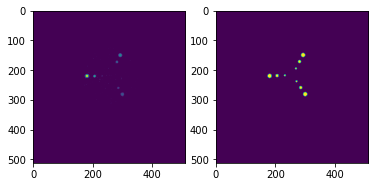

 10%|█         | 1/10 [00:12<01:56, 12.91s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep1


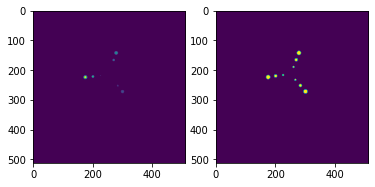

 20%|██        | 2/10 [00:26<01:44, 13.07s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep3


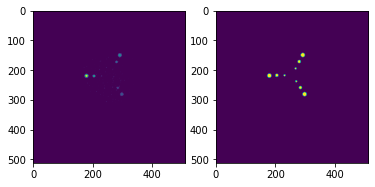

 30%|███       | 3/10 [00:38<01:30, 12.88s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep4


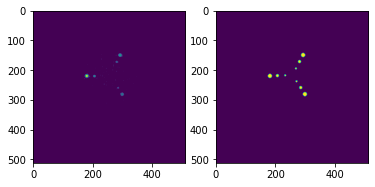

 40%|████      | 4/10 [00:51<01:16, 12.78s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep5


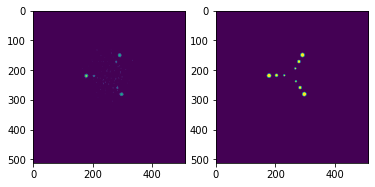

 50%|█████     | 5/10 [01:04<01:03, 12.79s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep2


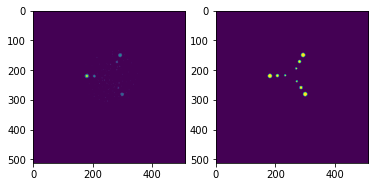

 60%|██████    | 6/10 [01:16<00:51, 12.75s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep4


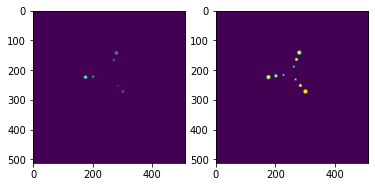

 70%|███████   | 7/10 [01:28<00:37, 12.40s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep3


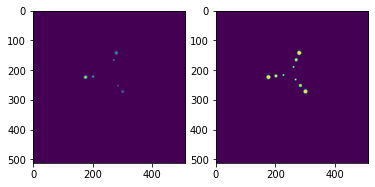

 80%|████████  | 8/10 [01:40<00:24, 12.18s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep2


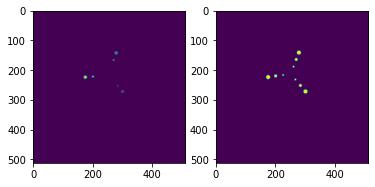

 90%|█████████ | 9/10 [01:52<00:12, 12.10s/it]

/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep5


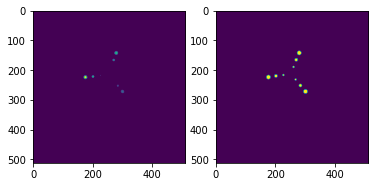

100%|██████████| 10/10 [02:04<00:00, 12.45s/it]
/Users/daleblack/Library/Python/3.8/lib/python/site-packages/xlsxwriter/workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [105]:
# For each path in dcm_path_list parse data
for idx in tqdm(range(len(dcm_path_list))):
    gc.collect()
    dcm_name = dcm_path_list[idx]
    print(dcm_name)
    try:
        header, dcm_array, slice_thick_ori = dcm_reader(dcm_path_list[idx])
        dcm_array_ori = dcm_array.copy()
        
        # set threshold, which is used for analysis, default is 130HU
        calcium_threshold = threshold_def(calcium_threshold_declaration)

        # set scoring method, used for CCS-scoring as defined by scoring_method:
        header.Manufacturer = scoring_method_selector()

        # mask insert of dcm_array
        dcm_array, center, mask = dcm_masked(array_used = dcm_array,\
                                                        slice_used_center = int(dcm_array.shape[2]/2))


    ###############################################################################
    #### CCI part
    ###############################################################################
        if phantom == 'CCI':
            # definitions for excel output
            column = 0
            
            # get slice with calcifications, thresholded image and quality slice
            calcium_image, CCI_slice, quality_slice, cal_rod_slice, flipped = CCI_calcium_image()
            
            # actual calcium scoring for CCI phantom
            calc_size_density_VS_AS_MS, center, mass_cal_factor,\
                calc_mean_dict, angle_0_200HA, water_rod, SNR_dict, CCI_mask_BAS =\
                            CCI_scoring(print_plot = True)
            
            # calculate image quality information
            quality_output = calcium_quality()
            
            Cal_rod_AS, Cal_rod_mean = Measurement_calrod(calcium_image[:,:,cal_rod_slice].copy()) 
            # Calculate MTF for 200mgHA insert
            
            quality_output['MTF'], quality_output['MTF0.5'], quality_output['ESF'] = MTF_200mgHA(plot_MTF = False)

            # Write results to excel
            row_used, row_NPS, row_MTF, row_IQ, row_ESF =\
                        write_CCI_to_excel(row_used, row_NPS, row_MTF, row_IQ, row_ESF)
                        
    ###############################################################################
    #### D100 part
    ###############################################################################
                    

    ###############################################################################
    #### Arteries part
    ###############################################################################
        elif phantom == 'arteries':

        
            # definitions for excel output
            column = 0
            int_factor = header.SliceThickness / header.PixelSpacing[0]

            # decrease insert size further to 80 mm; recalculate interpolated matrix
            dcm_array, mask = arteries_masked()
            if (Volume_score_calc and (header.Manufacturer == 'SIEMENS' or header.Manufacturer == 'Literature')):
                int_header, int_dcm_array = dcm_interpolation(dcm_array)
            
            # create calcium image and get index of both calcifications
            calcium_image, calc1, calc2 = Arteries_calcium_image()
            
            # calculate CCS for artery
            mass_cal_factor = 0.001
            scores_calc1, num_vox_1, mask_scoring = arteries_scoring(calc1)
            scores_calc2, num_vox_2, _ = arteries_scoring(calc2)
            
            quality_output = calcium_quality()
            quality_output['num_vox_calc1'] = num_vox_1
            quality_output['num_vox_calc2'] = num_vox_2
            
            row_used, row_NPS, row_IQ = write_Arteries_to_excel(row_used, row_NPS, row_IQ)

            
    except:
        not_used_sheet.write(row_not_used, 0, dcm_name)
        not_used_dir.append(dcm_name)
        #print(dcm_name)
        row_not_used += 1
                   
wb.close()